# XGBoost Model with Bayesian Optimization

## Purpose
This notebook trains XGBoost regression models to predict life expectancy using:
- **Bayesian hyperparameter optimization** for optimal model tuning
- **Multiple feature sets** (All Features, Top 20, Top 10, Top 5) for ablation study
- **Comprehensive evaluation** including SHAP analysis and residual diagnostics

## Input
- `data_cleaned/combined_final/final_combined_all_variables_reduced.csv` (from notebook 08)

## Output
- Publication-ready figures saved to: `data_cleaned/outputs_cleaned/modeling/xgboost/`
- Metrics tables (CSV format)
- Feature importance rankings

## Models Trained
1. **All Features Model** (~38 features)
2. **Top 20 Features Model**
3. **Top 10 Features Model**
4. **Top 5 Features Model**

## 1. Import Libraries and Setup

In [1]:
# Force clean install of compatible versions
#%pip uninstall -y scikit-optimize
#%pip install -q --no-cache-dir "scikit-optimize>=0.9.0"

# Verify versions
import numpy as np
print(f"NumPy version: {np.__version__}")
try:
    import skopt
    print(f"scikit-optimize version: {skopt.__version__}")
except:
    print("scikit-optimize not yet loaded")

NumPy version: 1.26.4
scikit-optimize version: 0.10.2


In [3]:
# Core libraries
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from scipy.stats import pearsonr
from skopt import BayesSearchCV
from skopt.space import Real, Integer

import shap
import warnings
warnings.filterwarnings('ignore')

## 2. Configuration and Output Setup

In [4]:
# Create output directory for publication figures
output_dir = '../data_cleaned/outputs_cleaned/modeling/xgboost/'
os.makedirs(output_dir, exist_ok=True)

# MDPI journal figure specifications
SINGLE_COL_WIDTH = 3.27  # inches (8.3 cm)
DOUBLE_COL_WIDTH = 6.85  # inches (17.4 cm)
DPI = 300  # Publication quality
FONT_SIZE = 11

# Set plotting style
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("husl")

print(f" Output directory created: {output_dir}")
print(f" Figure specifications: {DOUBLE_COL_WIDTH}in width, {DPI} DPI")

 Output directory created: ../data_cleaned/outputs_cleaned/modeling/xgboost/
 Figure specifications: 6.85in width, 300 DPI


## 3. Load Data

Load the final reduced dataset from notebook 08 with selected features only.

In [5]:
# Load final reduced dataset
df = pd.read_csv('../data_cleaned/combined_final/final_combined_all_variables_reduced.csv')

print("=" * 70)
print("DATASET LOADED")
print("=" * 70)
print(f"Shape: {df.shape}")
print(f"  - Rows: {df.shape[0]:,}")
print(f"  - Columns: {df.shape[1]}")
print(f"  - Years: {sorted(df['Year'].unique())}")
print(f"\nColumns: {list(df.columns)}")

DATASET LOADED
Shape: (24487, 45)
  - Rows: 24,487
  - Columns: 45
  - Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Columns: ['County', 'State', 'Mean Life Expectancy', 'Poverty Rate', "Bachelor's Degree or Higher (%)", 'Disability Rate', 'Total Population', 'Unemployment Rate', 'Year', 'White Population (%)', 'Hispanic Population (%)', 'Black Population (%)', 'Households with No Vehicle (%)', 'Single Mother Families (%)', 'Fips', 'Black Carbon AOD At 550 Nm', 'Dust AOD At 550 Nm', 'Land-sea Mask', 'Mean Sea Level Pressure', 'Organic Matter AOD At 550 Nm', 'Sea Salt AOD At 550 Nm', 'Sulphate AOD At 550 Nm', 'Leaf Area Index, High Vegetation', 'Leaf Area Index, Low Vegetation', 'Snow Depth', 'Relative Humidity', '10m Wind Speed', 'FoT Carbonmonoxide Above75ᵗʰ Percentile', 'FoT Ethane Above75ᵗʰ Percentile', 'FoT Formaldehyde Above75ᵗʰ Percentile', 'FoT Hydroxyl Radical Above75ᵗʰ Percentile', 'FoT Nitric Acid Above75ᵗʰ Percentile', 'FoT Nitrogen Dioxide Above75ᵗʰ Percentile', 

## 4. Model 1: All Features

### 4.1 Prepare Data

Split features and target, create train/test sets.

In [6]:
# Separate features and target
# Exclude identifiers (County, State, Year) and target variable
X = df.drop(columns=['County', 'State', 'Year', 'Fips', 'Mean Life Expectancy'])
y = df['Mean Life Expectancy']

# Keep Fips as groups for GroupKFold (prevents data leakage in panel data)
groups = df['Fips']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Groups (unique counties): {groups.nunique()}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"\nFeature list:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2}. {col}")

Features shape: (24487, 40)
Target shape: (24487,)
Groups (unique counties): 3061

Number of features: 40

Feature list:
   1. Poverty Rate
   2. Bachelor's Degree or Higher (%)
   3. Disability Rate
   4. Total Population
   5. Unemployment Rate
   6. White Population (%)
   7. Hispanic Population (%)
   8. Black Population (%)
   9. Households with No Vehicle (%)
  10. Single Mother Families (%)
  11. Black Carbon AOD At 550 Nm
  12. Dust AOD At 550 Nm
  13. Land-sea Mask
  14. Mean Sea Level Pressure
  15. Organic Matter AOD At 550 Nm
  16. Sea Salt AOD At 550 Nm
  17. Sulphate AOD At 550 Nm
  18. Leaf Area Index, High Vegetation
  19. Leaf Area Index, Low Vegetation
  20. Snow Depth
  21. Relative Humidity
  22. 10m Wind Speed
  23. FoT Carbonmonoxide Above75ᵗʰ Percentile
  24. FoT Ethane Above75ᵗʰ Percentile
  25. FoT Formaldehyde Above75ᵗʰ Percentile
  26. FoT Hydroxyl Radical Above75ᵗʰ Percentile
  27. FoT Nitric Acid Above75ᵗʰ Percentile
  28. FoT Nitrogen Dioxide Above75ᵗʰ Per

In [7]:
# Train/test split (80/20) using GroupShuffleSplit
# This ensures no county appears in both train and test sets (prevents data leakage)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]  # Keep groups for CV during training

# Verify no county overlap between train and test
train_counties = set(groups.iloc[train_idx])
test_counties = set(groups.iloc[test_idx])
overlap = train_counties.intersection(test_counties)

print("=" * 70)
print("TRAIN/TEST SPLIT (GroupShuffleSplit by County)")
print("=" * 70)
print(f"Training set:")
print(f"  - Shape: {X_train.shape}")
print(f"  - Samples: {X_train.shape[0]:,}")
print(f"  - Unique counties: {len(train_counties)}")
print(f"\nTest set:")
print(f"  - Shape: {X_test.shape}")
print(f"  - Samples: {X_test.shape[0]:,}")
print(f"  - Unique counties: {len(test_counties)}")
print(f"\nData leakage check:")
print(f"  - Counties in both train and test: {len(overlap)}")
print(f"  - Status: {' NO LEAKAGE' if len(overlap) == 0 else ' LEAKAGE DETECTED!'}")

TRAIN/TEST SPLIT (GroupShuffleSplit by County)
Training set:
  - Shape: (19583, 40)
  - Samples: 19,583
  - Unique counties: 2448

Test set:
  - Shape: (4904, 40)
  - Samples: 4,904
  - Unique counties: 613

Data leakage check:
  - Counties in both train and test: 0
  - Status:  NO LEAKAGE


### 4.2 Bayesian Hyperparameter Optimization

Use Bayesian search to find optimal XGBoost hyperparameters.

In [8]:
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'  # Use 'gpu_hist' if GPU available
)

print(" XGBoost model initialized")

 XGBoost model initialized


In [9]:
# Define Bayesian search space for hyperparameters
search_spaces = {
    "n_estimators":      Integer(400, 2000),                    # Number of trees
    "max_depth":         Integer(5, 10),                        # Tree depth (shallow to moderate)
    "learning_rate":     Real(0.005, 0.1, prior="log-uniform"), # Learning rate
    "subsample":         Real(0.6, 1.0),                        # Row sampling for stochasticity
    "colsample_bytree":  Real(0.6, 1.0),                        # Column sampling
    "reg_alpha":         Real(1e-4, 5.0, prior="log-uniform"),  # L1 regularization
    "reg_lambda":        Real(1e-2, 5.0, prior="log-uniform"),  # L2 regularization
    "min_child_weight":  Integer(1, 10),                        # Minimum leaf weight
}

# Initialize Bayesian search with 5-fold GroupKFold cross-validation
# GroupKFold ensures counties in validation fold never appear in training folds
bayes = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_spaces,
    n_iter=30,  # Number of parameter settings sampled
    cv=GroupKFold(n_splits=5),  # GroupKFold prevents county-level data leakage
    scoring="r2",
    n_jobs=-1,  # Use all available cores
    random_state=42,
    refit=True,  # Refit best model on full training set
    verbose=1,
)

print(" Bayesian search configured")
print(f"  - Iterations: 30")
print(f"  - Cross-validation: 5-fold GroupKFold (by county)")
print(f"  - Scoring metric: R²")

 Bayesian search configured
  - Iterations: 30
  - Cross-validation: 5-fold GroupKFold (by county)
  - Scoring metric: R²


In [10]:
# Run Bayesian optimization (this may take several minutes)
print("Starting Bayesian optimization...")
print("This may take 10-15 minutes depending on your hardware.")
print("Using GroupKFold to prevent county-level data leakage.\n")

# Pass groups to fit() for GroupKFold cross-validation
bayes.fit(X_train, y_train, groups=groups_train)

print("\n" + "=" * 70)
print("OPTIMIZATION COMPLETE")
print("=" * 70)
print(f"Best parameters found:")
for param, value in bayes.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nBest CV R² (mean over folds): {bayes.best_score_:.4f}")

Starting Bayesian optimization...
This may take 10-15 minutes depending on your hardware.
Using GroupKFold to prevent county-level data leakage.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 

### 4.3 Model Training and Predictions

In [11]:
# Get best model and make predictions
best_model = bayes.best_estimator_

train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

print(" Predictions generated for training and test sets")

 Predictions generated for training and test sets


### 4.4 Model Evaluation

In [12]:
# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)

# Calculate adjusted R²
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]  # Number of features

adj_r2_train = 1 - (1 - r2_train) * ((n_train - 1) / (n_train - p - 1))
adj_r2_test = 1 - (1 - r2_test) * ((n_test - 1) / (n_test - p - 1))

print("=" * 70)
print("MODEL PERFORMANCE METRICS (ALL FEATURES)")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  R² Score:       {r2_train:.4f}")
print(f"  Adjusted R²:    {adj_r2_train:.4f}")
print(f"  RMSE:           {train_rmse:.2f} years")
print(f"  MAE:            {train_mae:.2f} years")
print(f"\nTest Set:")
print(f"  R² Score:       {r2_test:.4f}")
print(f"  Adjusted R²:    {adj_r2_test:.4f}")
print(f"  RMSE:           {test_rmse:.2f} years")
print(f"  MAE:            {test_mae:.2f} years")

MODEL PERFORMANCE METRICS (ALL FEATURES)

Training Set:
  R² Score:       0.9816
  Adjusted R²:    0.9815
  RMSE:           0.34 years
  MAE:            0.26 years

Test Set:
  R² Score:       0.8483
  Adjusted R²:    0.8470
  RMSE:           0.99 years
  MAE:            0.75 years


In [13]:
# Create metrics summary table
metrics_summary_all = pd.DataFrame({
    'Metric': ['R² Score', 'Adjusted R²', 'RMSE (years)', 'MAE (years)', 'Sample Size'],
    'Training Set': [
        f'{r2_train:.3f}',
        f'{adj_r2_train:.3f}',
        f'{train_rmse:.2f}',
        f'{train_mae:.2f}',
        f'{len(y_train):,}'
    ],
    'Test Set': [
        f'{r2_test:.3f}',
        f'{adj_r2_test:.3f}',
        f'{test_rmse:.2f}',
        f'{test_mae:.2f}',
        f'{len(y_test):,}'
    ]
})

print("\nTable 1: Model Performance Metrics for All Features")
print("=" * 70)
display(metrics_summary_all)
print("=" * 70)

# Save to CSV
metrics_summary_all.to_csv(f'{output_dir}table1_metrics_all_features.csv', index=False)
print(f"\n Table saved to: {output_dir}table1_metrics_all_features.csv")


Table 1: Model Performance Metrics for All Features


,Metric,Training Set,Test Set
0,R² Score,0.982,0.848
1,Adjusted R²,0.982,0.847
2,RMSE (years),0.34,0.99
3,MAE (years),0.26,0.75
4,Sample Size,"19,583","4,904"



 Table saved to: ../data_cleaned/outputs_cleaned/modeling/xgboost/table1_metrics_all_features.csv


### 4.5 Scatter Plot: Predictions vs. Actual

Visualize model performance showing predicted vs. actual life expectancy.

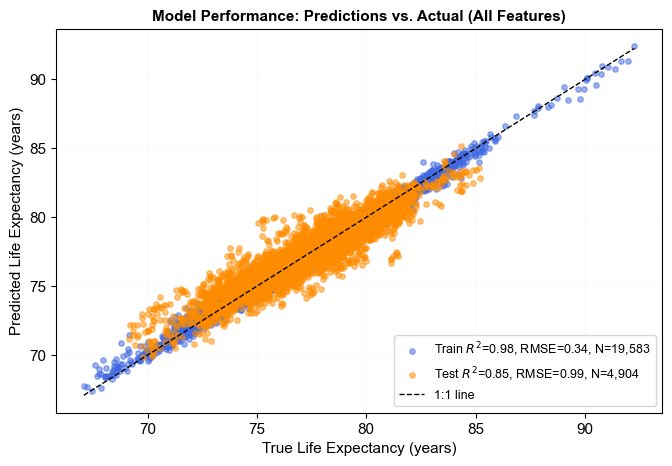

Figure 1: Scatter plot showing predicted vs. actual life expectancy for all features model.


In [14]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot training and test predictions with metrics in legend
ax.scatter(y_train, train_predictions, color='royalblue', 
           label=f'Train $R^2$={r2_train:.2f}, RMSE={train_rmse:.2f}, N={len(y_train):,}', 
           alpha=0.5, s=15)
ax.scatter(y_test, test_predictions, color='darkorange', 
           label=f'Test $R^2$={r2_test:.2f}, RMSE={test_rmse:.2f}, N={len(y_test):,}', 
           alpha=0.5, s=15)

# Add 1:1 reference line
ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        linestyle='--', color='black', linewidth=1, label='1:1 line')

# Labels and title
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_title(f'Model Performance: Predictions vs. Actual (All Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.legend(fontsize=9, frameon=True, loc='lower right')
ax.grid(axis='both', linewidth=0.15, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}fig1_scatter_performance_all_features.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 1: Scatter plot showing predicted vs. actual life expectancy for all features model.")

### 4.6 Q-Q Plot: Distribution Comparison

Quantile-Quantile plot to assess distributional agreement between predictions and actual values.

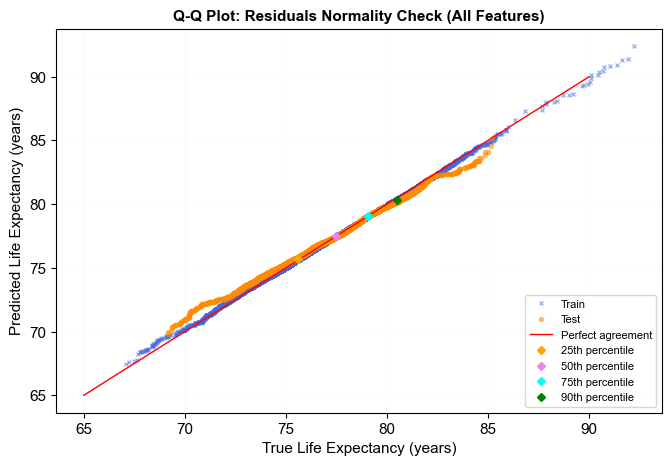

Figure 2: Q-Q plot comparing distributions with quantile markers for all features model.


In [15]:
# Sort predicted and target values
train_preds_sorted = np.sort(train_predictions)
train_targets_sorted = np.sort(y_train)

test_preds_sorted = np.sort(test_predictions)
test_targets_sorted = np.sort(y_test)

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot sorted values
ax.plot(train_targets_sorted, train_preds_sorted, 'x', 
        label='Train', alpha=0.5, color='royalblue', markersize=3)
ax.plot(test_targets_sorted, test_preds_sorted, 'o', 
        label='Test', alpha=0.5, color='darkorange', markersize=3)

# Draw 45-degree reference line
ax.plot([65, 90], [65, 90], 'r', linewidth=1, label='Perfect agreement')

# Calculate and plot percentile markers
all_predictions = np.concatenate((train_predictions, test_predictions))
all_targets = np.concatenate((y_train, y_test))

for percentile, color, label in [(25, 'orange', '25th'), (50, 'violet', '50th'), 
                                   (75, 'cyan', '75th'), (90, 'green', '90th')]:
    target_pct = np.percentile(np.sort(all_targets), percentile)
    pred_pct = np.percentile(np.sort(all_predictions), percentile)
    ax.plot(target_pct, pred_pct, marker="D", markersize=4, 
            color=color, linestyle='None', label=f"{label} percentile")

# Labels and title
ax.set_title(f'Q-Q Plot: Residuals Normality Check (All Features)', 
             fontsize=FONT_SIZE, fontweight="bold")
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.grid(axis='both', linewidth=0.15, alpha=0.3)
ax.legend(fontsize=8, frameon=True, loc='lower right')

plt.tight_layout()
plt.savefig(f'{output_dir}fig2_qq_plot_all_features.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 2: Q-Q plot comparing distributions with quantile markers for all features model.")

### 4.7 Permutation Importance

Calculate and visualize feature importance based on permutation.

In [16]:
# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, 
                                          n_repeats=10, random_state=42)

# Create DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(f" Permutation importance calculated for {len(perm_importance_df)} features")

 Permutation importance calculated for 40 features


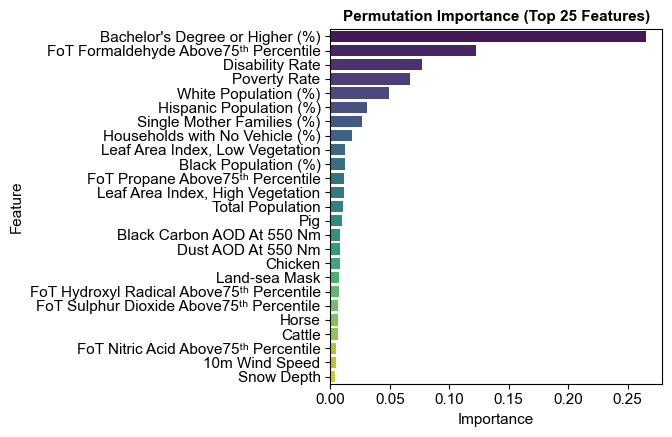

Figure 3: Permutation importance showing top 25 features for all features model.


In [17]:
# Plot top 25 features
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, 4.5))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(25), 
            palette='viridis', ax=ax)
ax.set_title('Permutation Importance (Top 25 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.set_xlabel('Importance', fontsize=FONT_SIZE)
ax.set_ylabel('Feature', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig3_permutation_importance_all_features.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 3: Permutation importance showing top 25 features for all features model.")

### 4.8 SHAP Analysis

#### 4.8.1 SHAP Summary Plot

In [18]:
# Create SHAP explainer
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
print("Computing SHAP values...")
shap_values = explainer.shap_values(X_test)

print(f" SHAP values computed for {X_test.shape[0]:,} test samples")

Creating SHAP explainer...
Computing SHAP values...
 SHAP values computed for 4,904 test samples


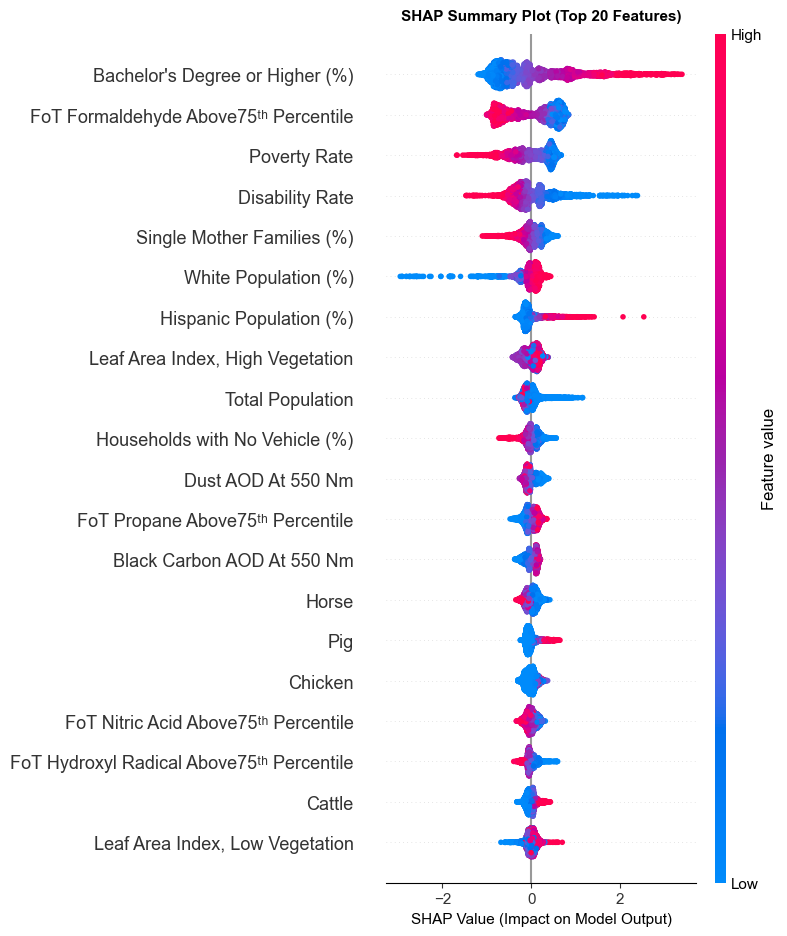

Figure 4: SHAP summary plot showing feature importance and impact direction.


In [19]:
# SHAP summary plot (colored by feature value)
plt.figure(figsize=(DOUBLE_COL_WIDTH, 5))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('SHAP Summary Plot (Top 20 Features)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig4_shap_summary_all_features.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 4: SHAP summary plot showing feature importance and impact direction.")

#### 4.8.2 SHAP Bar Plot

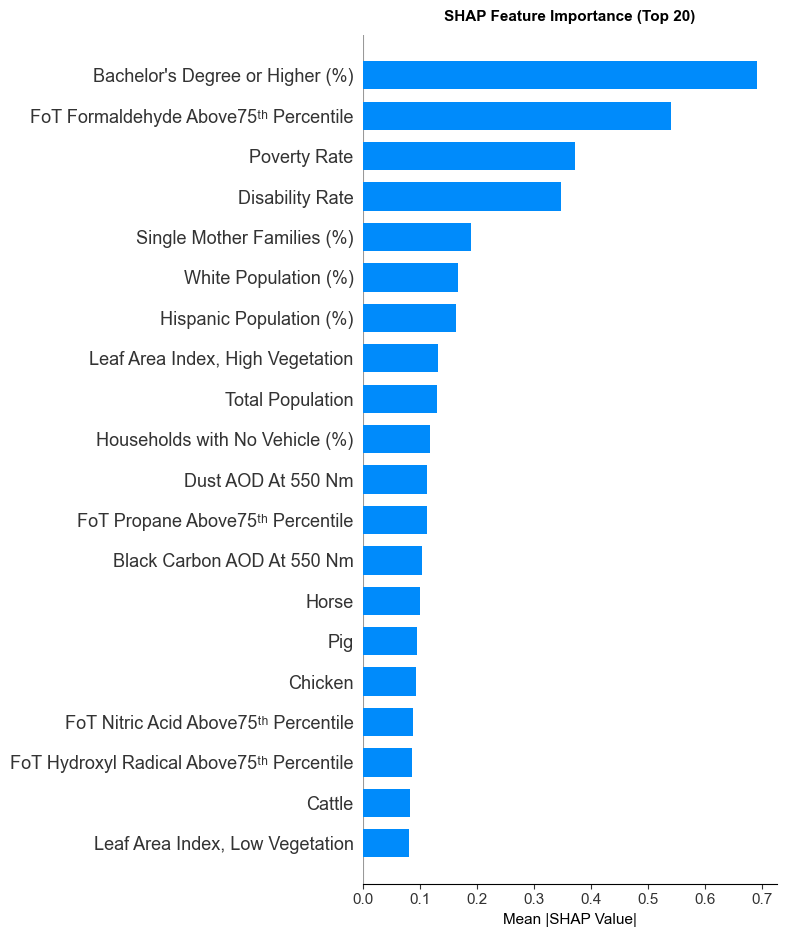

Figure 5: SHAP bar plot showing mean absolute SHAP values.


In [20]:
# SHAP bar plot (mean absolute SHAP values)
plt.figure(figsize=(SINGLE_COL_WIDTH, 4))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance (Top 20)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('Mean |SHAP Value|', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig5_shap_bar_all_features.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 5: SHAP bar plot showing mean absolute SHAP values.")

#### 4.8.3 SHAP Dependence Plots

Show how individual features impact predictions across their value range.

In [21]:
# Get top 3 features by mean absolute SHAP value
shap_importance = np.abs(shap_values).mean(axis=0)
top_3_indices = np.argsort(shap_importance)[-3:][::-1]
top_3_features = [X_test.columns[i] for i in top_3_indices]

print(f"Top 3 features for dependence plots: {top_3_features}")

Top 3 features for dependence plots: ["Bachelor's Degree or Higher (%)", 'FoT Formaldehyde Above75ᵗʰ Percentile', 'Poverty Rate']


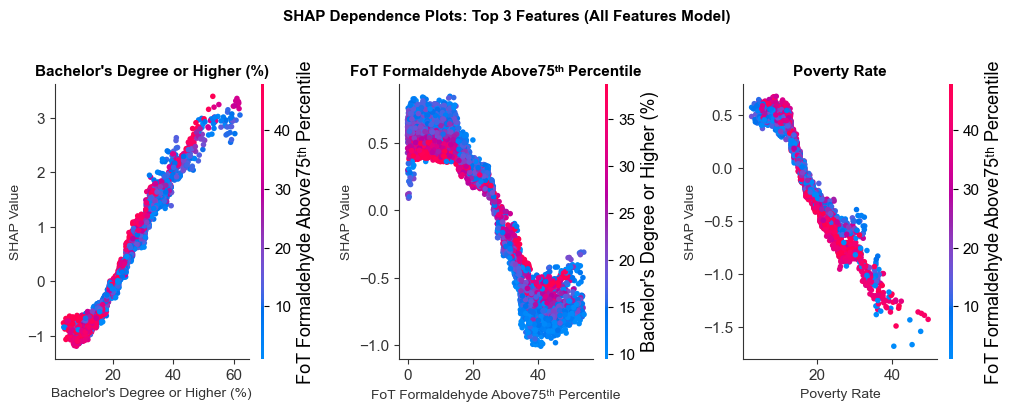

Figure 6: SHAP dependence plots showing non-linear relationships for top 3 features.


In [22]:
# Create SHAP dependence plots for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(DOUBLE_COL_WIDTH * 1.5, 4))

for idx, feature in enumerate(top_3_features):
    shap.dependence_plot(feature, shap_values, X_test, ax=axes[idx], show=False)
    axes[idx].set_title(f'{feature}', fontsize=FONT_SIZE, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=FONT_SIZE-1)
    axes[idx].set_ylabel('SHAP Value', fontsize=FONT_SIZE-1)

plt.suptitle('SHAP Dependence Plots: Top 3 Features (All Features Model)', 
             fontsize=FONT_SIZE, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}fig6_shap_dependence_all_features.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 6: SHAP dependence plots showing non-linear relationships for top 3 features.")

## 5. Model 2: Top 20 Features

### 5.1 Extract Top 20 Features

Select the top 20 most important features based on SHAP values from the all features model.

In [23]:
# Get top 20 features by mean absolute SHAP value
shap_importance_all = np.abs(shap_values).mean(axis=0)
top_20_indices = np.argsort(shap_importance_all)[-20:][::-1]
top_20_features = [X_test.columns[i] for i in top_20_indices]

print("=" * 70)
print("TOP 20 FEATURES (by SHAP importance)")
print("=" * 70)
for i, feat in enumerate(top_20_features, 1):
    print(f"  {i:2}. {feat}")
print("=" * 70)

# Create subset with top 20 features
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

print(f"\n Top 20 features selected")
print(f"  Training set shape: {X_train_top20.shape}")
print(f"  Test set shape: {X_test_top20.shape}")

TOP 20 FEATURES (by SHAP importance)
   1. Bachelor's Degree or Higher (%)
   2. FoT Formaldehyde Above75ᵗʰ Percentile
   3. Poverty Rate
   4. Disability Rate
   5. Single Mother Families (%)
   6. White Population (%)
   7. Hispanic Population (%)
   8. Leaf Area Index, High Vegetation
   9. Total Population
  10. Households with No Vehicle (%)
  11. Dust AOD At 550 Nm
  12. FoT Propane Above75ᵗʰ Percentile
  13. Black Carbon AOD At 550 Nm
  14. Horse
  15. Pig
  16. Chicken
  17. FoT Nitric Acid Above75ᵗʰ Percentile
  18. FoT Hydroxyl Radical Above75ᵗʰ Percentile
  19. Cattle
  20. Leaf Area Index, Low Vegetation

 Top 20 features selected
  Training set shape: (19583, 20)
  Test set shape: (4904, 20)


### 5.2 Correlation Heatmap

Visualize correlations among the top 20 features.

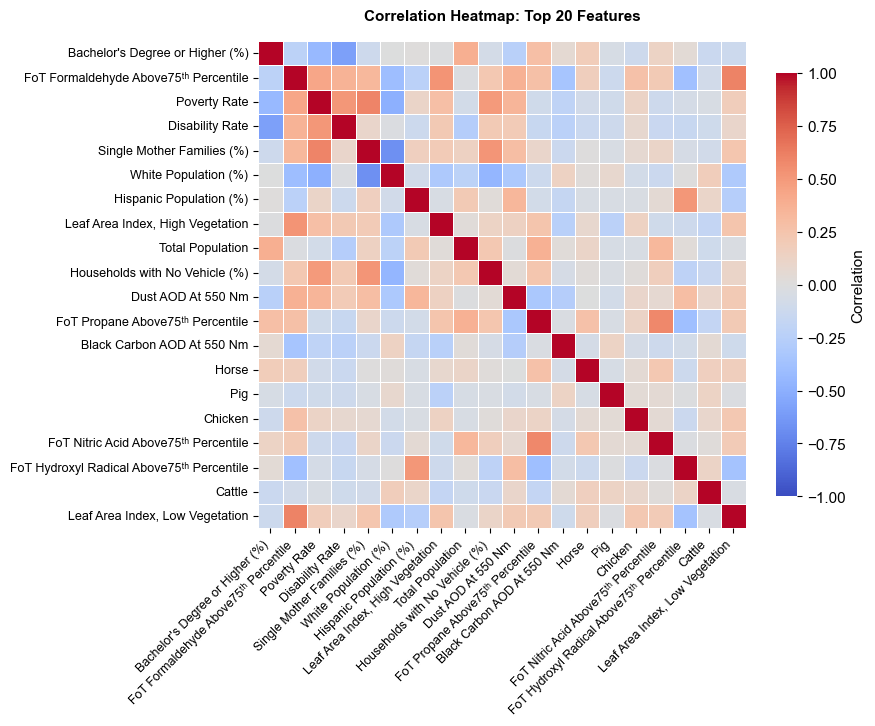

Figure 7A: Full correlation heatmap for top 20 features.


In [24]:
# Calculate correlation matrix
corr_matrix_top20 = X_train_top20.corr()

# Create full square correlation heatmap (no upper triangle mask)
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH * 1.3, DOUBLE_COL_WIDTH * 1.1))
sns.heatmap(corr_matrix_top20, 
            cmap='coolwarm', 
            center=0, 
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            vmin=-1, vmax=1,
            ax=ax)
ax.set_title('Correlation Heatmap: Top 20 Features', 
             fontsize=FONT_SIZE, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(f'{output_dir}fig7a_correlation_heatmap_top20.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 7A: Full correlation heatmap for top 20 features.")

### 5.3 Bayesian Optimization for Top 20 Features

In [25]:
# Initialize model for top 20 features
xgb_model_top20 = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)

# Run Bayesian optimization with GroupKFold
bayes_top20 = BayesSearchCV(
    estimator=xgb_model_top20,
    search_spaces=search_spaces,
    n_iter=30,
    cv=GroupKFold(n_splits=5),  # GroupKFold prevents county-level data leakage
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1,
)

print("Starting Bayesian optimization for Top 20 features...")
print("Using GroupKFold to prevent county-level data leakage.")
print("This may take 10-15 minutes...\n")

# Pass groups to fit() for GroupKFold cross-validation
bayes_top20.fit(X_train_top20, y_train, groups=groups_train)

print("\n" + "=" * 70)
print("OPTIMIZATION COMPLETE (TOP 20 FEATURES)")
print("=" * 70)
print(f"Best parameters found:")
for param, value in bayes_top20.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nBest CV R²: {bayes_top20.best_score_:.4f}")

Starting Bayesian optimization for Top 20 features...
Using GroupKFold to prevent county-level data leakage.
This may take 10-15 minutes...

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 can

### 5.4 Model Training and Evaluation

In [26]:
# Get best model and make predictions
best_model_top20 = bayes_top20.best_estimator_

train_predictions_top20 = best_model_top20.predict(X_train_top20)
test_predictions_top20 = best_model_top20.predict(X_test_top20)

# Calculate metrics
train_rmse_top20 = np.sqrt(mean_squared_error(y_train, train_predictions_top20))
test_rmse_top20 = np.sqrt(mean_squared_error(y_test, test_predictions_top20))

train_mae_top20 = mean_absolute_error(y_train, train_predictions_top20)
test_mae_top20 = mean_absolute_error(y_test, test_predictions_top20)

r2_train_top20 = r2_score(y_train, train_predictions_top20)
r2_test_top20 = r2_score(y_test, test_predictions_top20)

# Calculate adjusted R²
p_top20 = X_train_top20.shape[1]
adj_r2_train_top20 = 1 - (1 - r2_train_top20) * ((n_train - 1) / (n_train - p_top20 - 1))
adj_r2_test_top20 = 1 - (1 - r2_test_top20) * ((n_test - 1) / (n_test - p_top20 - 1))

print("=" * 70)
print("MODEL PERFORMANCE METRICS (TOP 20 FEATURES)")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  R² Score:       {r2_train_top20:.4f}")
print(f"  Adjusted R²:    {adj_r2_train_top20:.4f}")
print(f"  RMSE:           {train_rmse_top20:.2f} years")
print(f"  MAE:            {train_mae_top20:.2f} years")
print(f"\nTest Set:")
print(f"  R² Score:       {r2_test_top20:.4f}")
print(f"  Adjusted R²:    {adj_r2_test_top20:.4f}")
print(f"  RMSE:           {test_rmse_top20:.2f} years")
print(f"  MAE:            {test_mae_top20:.2f} years")

MODEL PERFORMANCE METRICS (TOP 20 FEATURES)

Training Set:
  R² Score:       0.9681
  Adjusted R²:    0.9680
  RMSE:           0.45 years
  MAE:            0.35 years

Test Set:
  R² Score:       0.8375
  Adjusted R²:    0.8368
  RMSE:           1.02 years
  MAE:            0.78 years


In [27]:
# Create metrics summary table
metrics_summary_top20 = pd.DataFrame({
    'Metric': ['R² Score', 'Adjusted R²', 'RMSE (years)', 'MAE (years)', 'Sample Size'],
    'Training Set': [
        f'{r2_train_top20:.3f}',
        f'{adj_r2_train_top20:.3f}',
        f'{train_rmse_top20:.2f}',
        f'{train_mae_top20:.2f}',
        f'{len(y_train):,}'
    ],
    'Test Set': [
        f'{r2_test_top20:.3f}',
        f'{adj_r2_test_top20:.3f}',
        f'{test_rmse_top20:.2f}',
        f'{test_mae_top20:.2f}',
        f'{len(y_test):,}'
    ]
})

print("\nTable 2: Model Performance Metrics for Top 20 Features")
print("=" * 70)
display(metrics_summary_top20)
print("=" * 70)

# Save to CSV
metrics_summary_top20.to_csv(f'{output_dir}table2_metrics_top20_features.csv', index=False)
print(f"\n Table saved to: {output_dir}table2_metrics_top20_features.csv")


Table 2: Model Performance Metrics for Top 20 Features


,Metric,Training Set,Test Set
0,R² Score,0.968,0.837
1,Adjusted R²,0.968,0.837
2,RMSE (years),0.45,1.02
3,MAE (years),0.35,0.78
4,Sample Size,"19,583","4,904"



 Table saved to: ../data_cleaned/outputs_cleaned/modeling/xgboost/table2_metrics_top20_features.csv


### 5.5 Residual Analysis

Diagnostic plots to assess model assumptions and identify patterns in residuals.

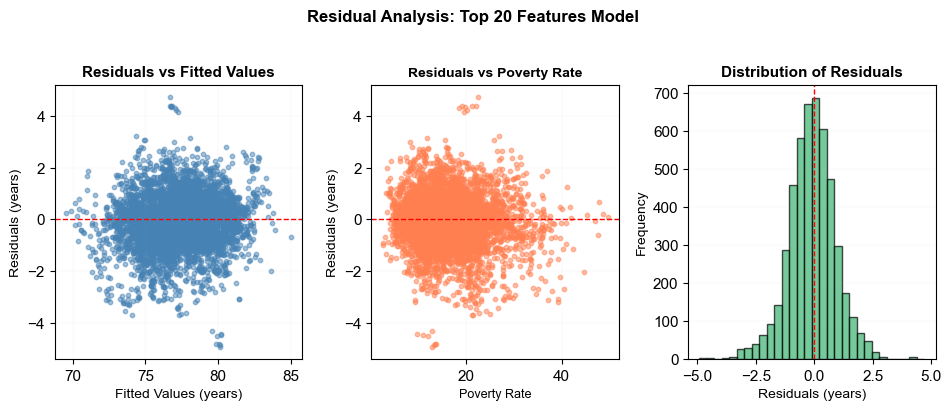

Figure 7B: Residual analysis with three diagnostic plots for top 20 features model.


In [28]:
# Calculate residuals
residuals_top20 = y_test - test_predictions_top20

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(DOUBLE_COL_WIDTH * 1.4, 4))

# Subplot 1: Residuals vs Fitted Values
axes[0].scatter(test_predictions_top20, residuals_top20, alpha=0.5, s=10, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Fitted Values (years)', fontsize=FONT_SIZE-1)
axes[0].set_ylabel('Residuals (years)', fontsize=FONT_SIZE-1)
axes[0].set_title('Residuals vs Fitted Values', fontsize=FONT_SIZE, fontweight='bold')
axes[0].grid(axis='both', linewidth=0.15, alpha=0.3)

# Subplot 2: Residuals vs Poverty Rate (if available in top 20)
# Check if poverty-related feature exists in top 20
poverty_features = [f for f in top_20_features if 'Poverty' in f or 'poverty' in f.lower()]
if poverty_features:
    poverty_col = poverty_features[0]
    axes[1].scatter(X_test_top20[poverty_col], residuals_top20, alpha=0.5, s=10, color='coral')
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[1].set_xlabel(poverty_col, fontsize=FONT_SIZE-2)
    axes[1].set_ylabel('Residuals (years)', fontsize=FONT_SIZE-1)
    axes[1].set_title(f'Residuals vs {poverty_col}', fontsize=FONT_SIZE-1, fontweight='bold')
    axes[1].grid(axis='both', linewidth=0.15, alpha=0.3)
else:
    # Use first feature if no poverty feature
    first_feature = top_20_features[0]
    axes[1].scatter(X_test_top20[first_feature], residuals_top20, alpha=0.5, s=10, color='coral')
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[1].set_xlabel(first_feature, fontsize=FONT_SIZE-2)
    axes[1].set_ylabel('Residuals (years)', fontsize=FONT_SIZE-1)
    axes[1].set_title(f'Residuals vs {first_feature}', fontsize=FONT_SIZE-1, fontweight='bold')
    axes[1].grid(axis='both', linewidth=0.15, alpha=0.3)

# Subplot 3: Histogram of Residuals
axes[2].hist(residuals_top20, bins=30, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[2].set_xlabel('Residuals (years)', fontsize=FONT_SIZE-1)
axes[2].set_ylabel('Frequency', fontsize=FONT_SIZE-1)
axes[2].set_title('Distribution of Residuals', fontsize=FONT_SIZE, fontweight='bold')
axes[2].grid(axis='y', linewidth=0.15, alpha=0.3)

plt.suptitle('Residual Analysis: Top 20 Features Model', 
             fontsize=FONT_SIZE+1, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}fig7b_residual_analysis_top20.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 7B: Residual analysis with three diagnostic plots for top 20 features model.")

### 5.6 Scatter Plot: Predictions vs. Actual

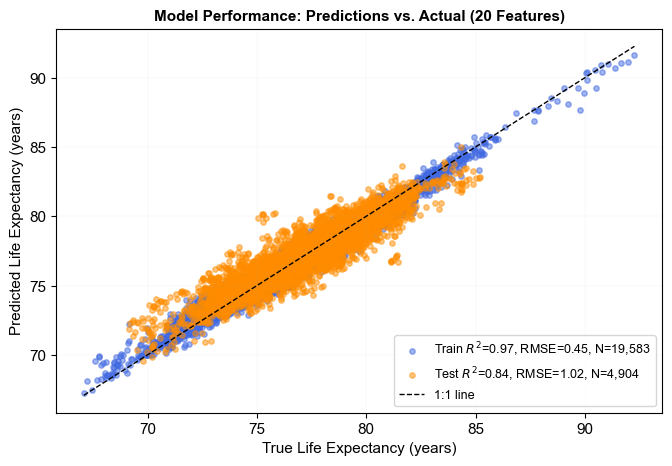

Figure 8: Scatter plot for top 20 features model.


In [29]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot training and test predictions with metrics in legend
ax.scatter(y_train, train_predictions_top20, color='royalblue', 
           label=f'Train $R^2$={r2_train_top20:.2f}, RMSE={train_rmse_top20:.2f}, N={len(y_train):,}', 
           alpha=0.5, s=15)
ax.scatter(y_test, test_predictions_top20, color='darkorange', 
           label=f'Test $R^2$={r2_test_top20:.2f}, RMSE={test_rmse_top20:.2f}, N={len(y_test):,}', 
           alpha=0.5, s=15)

# Add 1:1 reference line
ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        linestyle='--', color='black', linewidth=1, label='1:1 line')

# Labels and title
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_title(f'Model Performance: Predictions vs. Actual (20 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.legend(fontsize=9, frameon=True, loc='lower right')
ax.grid(axis='both', linewidth=0.15, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}fig8_scatter_performance_top20.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 8: Scatter plot for top 20 features model.")

### 5.7 Q-Q Plot

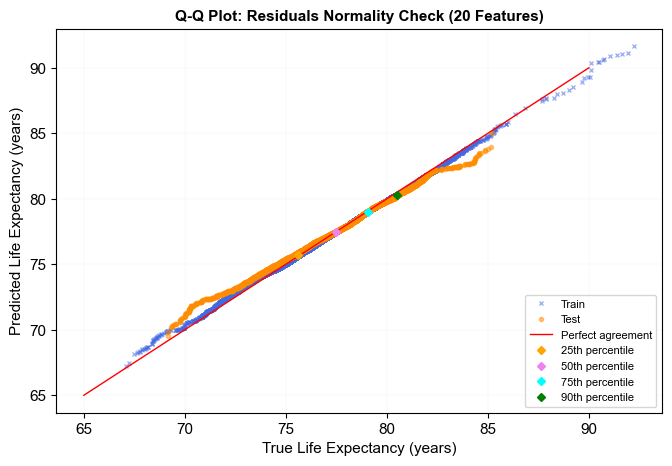

Figure 9: Q-Q plot for top 20 features model.


In [30]:
# Sort predicted and target values
train_preds_sorted_top20 = np.sort(train_predictions_top20)
train_targets_sorted_top20 = np.sort(y_train)

test_preds_sorted_top20 = np.sort(test_predictions_top20)
test_targets_sorted_top20 = np.sort(y_test)

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot sorted values
ax.plot(train_targets_sorted_top20, train_preds_sorted_top20, 'x', 
        label='Train', alpha=0.5, color='royalblue', markersize=3)
ax.plot(test_targets_sorted_top20, test_preds_sorted_top20, 'o', 
        label='Test', alpha=0.5, color='darkorange', markersize=3)

# Draw 45-degree reference line
ax.plot([65, 90], [65, 90], 'r', linewidth=1, label='Perfect agreement')

# Calculate and plot percentile markers
all_predictions_top20 = np.concatenate((train_predictions_top20, test_predictions_top20))

for percentile, color, label in [(25, 'orange', '25th'), (50, 'violet', '50th'), 
                                   (75, 'cyan', '75th'), (90, 'green', '90th')]:
    target_pct = np.percentile(np.sort(all_targets), percentile)
    pred_pct = np.percentile(np.sort(all_predictions_top20), percentile)
    ax.plot(target_pct, pred_pct, marker="D", markersize=4, 
            color=color, linestyle='None', label=f"{label} percentile")

# Labels and title
ax.set_title(f'Q-Q Plot: Residuals Normality Check (20 Features)', 
             fontsize=FONT_SIZE, fontweight="bold")
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.grid(axis='both', linewidth=0.15, alpha=0.3)
ax.legend(fontsize=8, frameon=True, loc='lower right')

plt.tight_layout()
plt.savefig(f'{output_dir}fig9_qq_plot_top20.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 9: Q-Q plot for top 20 features model.")

### 5.8 Permutation Importance

In [31]:
# Calculate permutation importance
print("Calculating permutation importance for top 20 features...")
perm_importance_top20 = permutation_importance(best_model_top20, X_test_top20, y_test, 
                                                n_repeats=10, random_state=42)

# Create DataFrame for visualization
perm_importance_df_top20 = pd.DataFrame({
    'Feature': X_test_top20.columns,
    'Importance': perm_importance_top20.importances_mean
}).sort_values(by='Importance', ascending=False)

print(f" Permutation importance calculated")

Calculating permutation importance for top 20 features...
 Permutation importance calculated


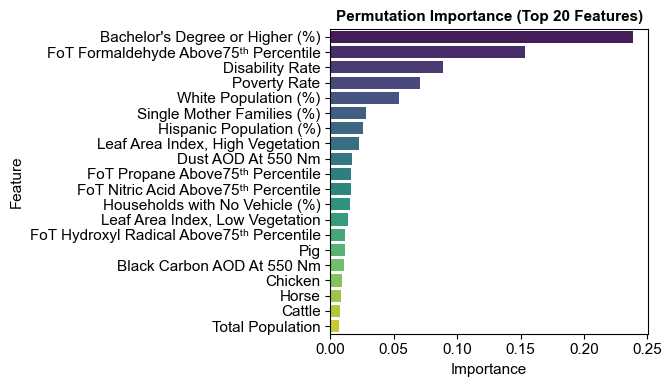

Figure 10: Permutation importance for top 20 features model.


In [32]:
# Plot all 20 features
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, 4))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_top20, 
            palette='viridis', ax=ax)
ax.set_title('Permutation Importance (Top 20 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.set_xlabel('Importance', fontsize=FONT_SIZE)
ax.set_ylabel('Feature', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig10_permutation_importance_top20.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 10: Permutation importance for top 20 features model.")

### 5.9 SHAP Analysis

#### 5.9.1 SHAP Summary Plot

In [33]:
# Create SHAP explainer and compute values
print("Computing SHAP values for top 20 features...")
explainer_top20 = shap.TreeExplainer(best_model_top20)
shap_values_top20 = explainer_top20.shap_values(X_test_top20)

print(f" SHAP values computed")

Computing SHAP values for top 20 features...
 SHAP values computed


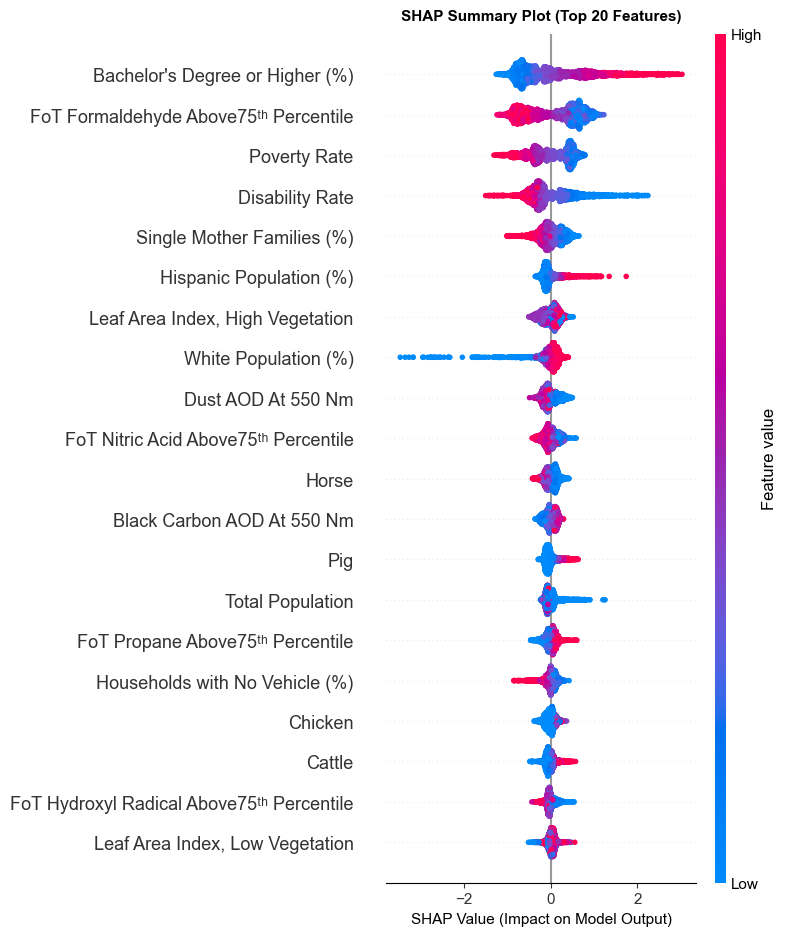

Figure 11: SHAP summary plot for top 20 features model.


In [34]:
# SHAP summary plot (colored by feature value)
plt.figure(figsize=(DOUBLE_COL_WIDTH, 5))
shap.summary_plot(shap_values_top20, X_test_top20, max_display=20, show=False)
plt.title('SHAP Summary Plot (Top 20 Features)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig11_shap_summary_top20.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 11: SHAP summary plot for top 20 features model.")

#### 5.9.2 SHAP Bar Plot

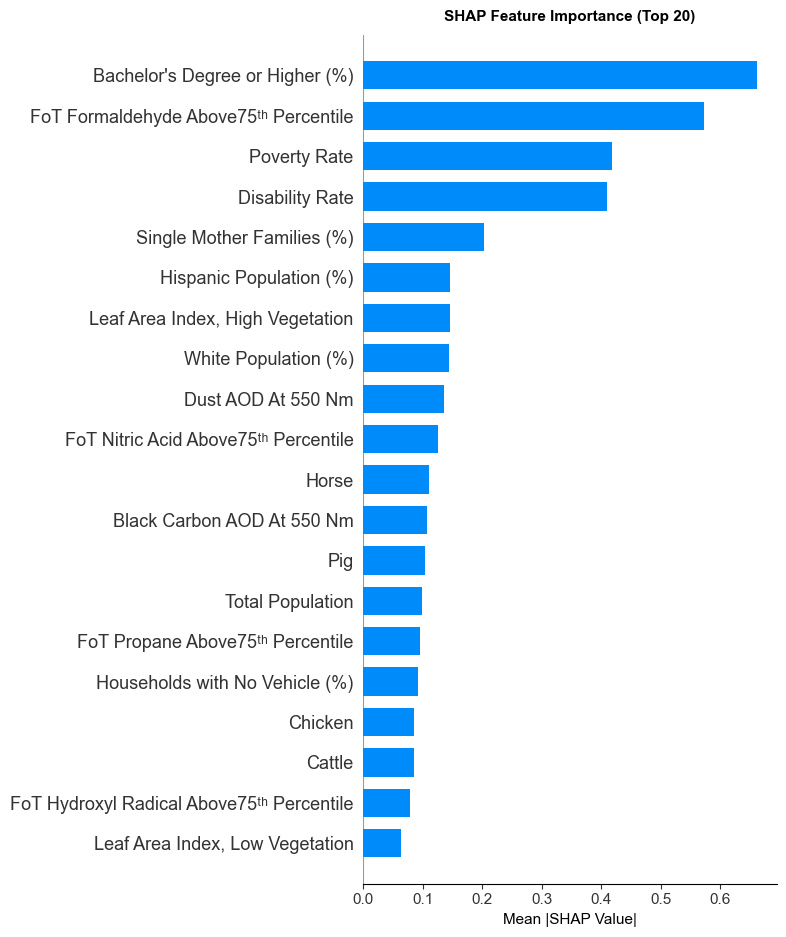

Figure 12: SHAP bar plot for top 20 features model.


In [35]:
# SHAP bar plot (mean absolute SHAP values)
plt.figure(figsize=(SINGLE_COL_WIDTH, 4))
shap.summary_plot(shap_values_top20, X_test_top20, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance (Top 20)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('Mean |SHAP Value|', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig12_shap_bar_top20.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 12: SHAP bar plot for top 20 features model.")

#### 5.9.3 SHAP Dependence Plots

In [36]:
# Get top 3 features by mean absolute SHAP value
shap_importance_top20 = np.abs(shap_values_top20).mean(axis=0)
top_3_indices_top20 = np.argsort(shap_importance_top20)[-3:][::-1]
top_3_features_top20 = [X_test_top20.columns[i] for i in top_3_indices_top20]

print(f"Top 3 features for dependence plots: {top_3_features_top20}")

Top 3 features for dependence plots: ["Bachelor's Degree or Higher (%)", 'FoT Formaldehyde Above75ᵗʰ Percentile', 'Poverty Rate']


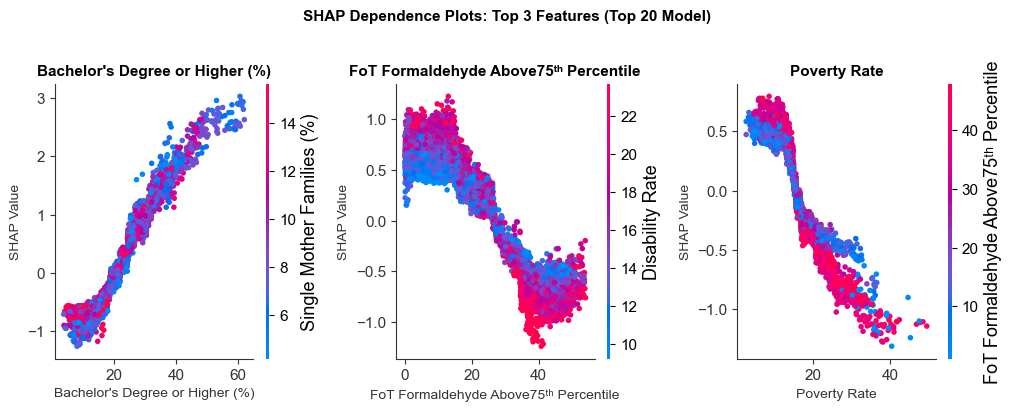

Figure 13: SHAP dependence plots for top 20 features model.


In [37]:
# Create SHAP dependence plots for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(DOUBLE_COL_WIDTH * 1.5, 4))

for idx, feature in enumerate(top_3_features_top20):
    shap.dependence_plot(feature, shap_values_top20, X_test_top20, ax=axes[idx], show=False)
    axes[idx].set_title(f'{feature}', fontsize=FONT_SIZE, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=FONT_SIZE-1)
    axes[idx].set_ylabel('SHAP Value', fontsize=FONT_SIZE-1)

plt.suptitle('SHAP Dependence Plots: Top 3 Features (Top 20 Model)', 
             fontsize=FONT_SIZE, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}fig13_shap_dependence_top20.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 13: SHAP dependence plots for top 20 features model.")

### 5.10 Cross-Validation Performance

Evaluate model stability using cross-validation on the test set.

In [38]:
# Perform 5-fold cross-validation on full dataset
print("Performing cross-validation for top 20 features...")
cv_scores_r2_top20 = cross_val_score(best_model_top20, X, y, 
                                      cv=5, scoring='r2', n_jobs=-1)
cv_scores_rmse_top20 = -cross_val_score(best_model_top20, X, y, 
                                         cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print(f" Cross-validation complete")
print(f"  R² scores: {cv_scores_r2_top20}")
print(f"  RMSE scores: {cv_scores_rmse_top20}")
print(f"  Mean R²: {cv_scores_r2_top20.mean():.4f} (+/- {cv_scores_r2_top20.std():.4f})")
print(f"  Mean RMSE: {cv_scores_rmse_top20.mean():.2f} (+/- {cv_scores_rmse_top20.std():.2f})")

Performing cross-validation for top 20 features...
 Cross-validation complete
  R² scores: [0.90937642 0.9273276  0.93543599 0.92274483 0.90200739]
  RMSE scores: [0.73830597 0.66695919 0.64306096 0.72137161 0.81693747]
  Mean R²: 0.9194 (+/- 0.0121)
  Mean RMSE: 0.72 (+/- 0.06)


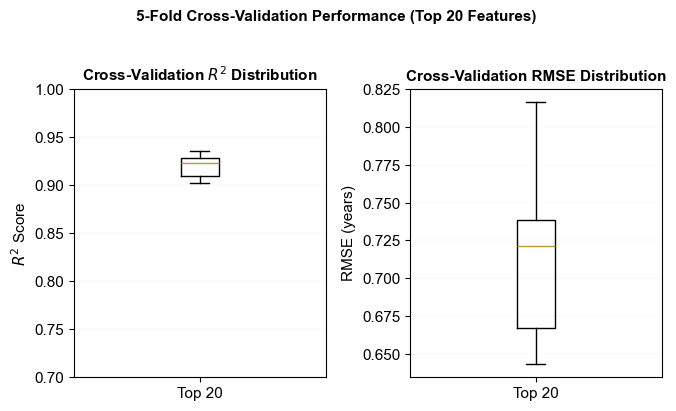

Figure 14: Cross-validation performance distributions for top 20 features model.


In [39]:
# Create boxplots for cross-validation scores
fig, axes = plt.subplots(1, 2, figsize=(DOUBLE_COL_WIDTH, 4))

# R² boxplot
axes[0].boxplot([cv_scores_r2_top20], labels=['Top 20'])
axes[0].set_ylabel('$R^2$ Score', fontsize=FONT_SIZE)
axes[0].set_title('Cross-Validation $R^2$ Distribution', fontsize=FONT_SIZE, fontweight='bold')
axes[0].grid(axis='y', linewidth=0.15, alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# RMSE boxplot
axes[1].boxplot([cv_scores_rmse_top20], labels=['Top 20'])
axes[1].set_ylabel('RMSE (years)', fontsize=FONT_SIZE)
axes[1].set_title('Cross-Validation RMSE Distribution', fontsize=FONT_SIZE, fontweight='bold')
axes[1].grid(axis='y', linewidth=0.15, alpha=0.3)

plt.suptitle('5-Fold Cross-Validation Performance (Top 20 Features)', 
             fontsize=FONT_SIZE, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}fig14_cross_validation_top20.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 14: Cross-validation performance distributions for top 20 features model.")

## 6. Model 3: Top 10 Features

### 6.1 Extract Top 10 Features

Select the top 10 most important features based on SHAP values from the top 20 model.

In [40]:
# Get top 10 features by mean absolute SHAP value from top 20 model
top_10_indices = np.argsort(shap_importance_top20)[-10:][::-1]
top_10_features = [X_test_top20.columns[i] for i in top_10_indices]

print("=" * 70)
print("TOP 10 FEATURES (by SHAP importance from Top 20)")
print("=" * 70)
for i, feat in enumerate(top_10_features, 1):
    print(f"  {i:2}. {feat}")
print("=" * 70)

# Create subset with top 10 features
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

print(f"\n Top 10 features selected")
print(f"  Training set shape: {X_train_top10.shape}")
print(f"  Test set shape: {X_test_top10.shape}")

TOP 10 FEATURES (by SHAP importance from Top 20)
   1. Bachelor's Degree or Higher (%)
   2. FoT Formaldehyde Above75ᵗʰ Percentile
   3. Poverty Rate
   4. Disability Rate
   5. Single Mother Families (%)
   6. Hispanic Population (%)
   7. Leaf Area Index, High Vegetation
   8. White Population (%)
   9. Dust AOD At 550 Nm
  10. FoT Nitric Acid Above75ᵗʰ Percentile

 Top 10 features selected
  Training set shape: (19583, 10)
  Test set shape: (4904, 10)


### 6.2 Correlation Heatmap with Annotations

Visualize correlations among the top 10 features with annotated values.

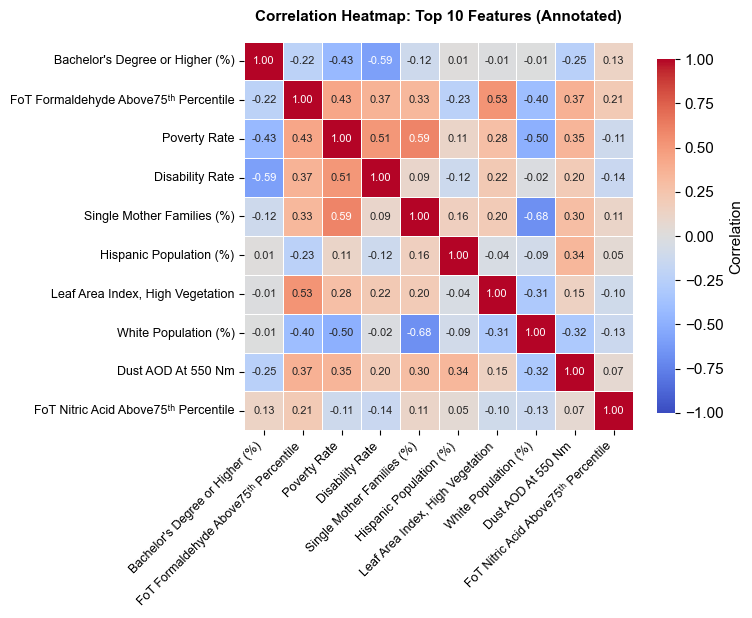

Figure 15A: Annotated correlation heatmap for top 10 features.


In [41]:
# Calculate correlation matrix
corr_matrix_top10 = X_train_top10.corr()

# Create full square correlation heatmap WITH annotations
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH * 1.1, DOUBLE_COL_WIDTH * 0.95))
sns.heatmap(corr_matrix_top10, 
            annot=True,  # Show correlation values
            fmt='.2f',   # Format to 2 decimal places
            cmap='coolwarm', 
            center=0, 
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            vmin=-1, vmax=1,
            ax=ax,
            annot_kws={"size": 8})
ax.set_title('Correlation Heatmap: Top 10 Features (Annotated)', 
             fontsize=FONT_SIZE, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(f'{output_dir}fig15a_correlation_heatmap_top10.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 15A: Annotated correlation heatmap for top 10 features.")

### 6.3 Bayesian Optimization for Top 10 Features

In [42]:
# Initialize model for top 10 features
xgb_model_top10 = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)

# Run Bayesian optimization with GroupKFold
bayes_top10 = BayesSearchCV(
    estimator=xgb_model_top10,
    search_spaces=search_spaces,
    n_iter=30,
    cv=GroupKFold(n_splits=5),  # GroupKFold prevents county-level data leakage
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1,
)

print("Starting Bayesian optimization for Top 10 features...")
print("Using GroupKFold to prevent county-level data leakage.")
print("This may take 10-15 minutes...\n")

# Pass groups to fit() for GroupKFold cross-validation
bayes_top10.fit(X_train_top10, y_train, groups=groups_train)

print("\n" + "=" * 70)
print("OPTIMIZATION COMPLETE (TOP 10 FEATURES)")
print("=" * 70)
print(f"Best parameters found:")
for param, value in bayes_top10.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nBest CV R²: {bayes_top10.best_score_:.4f}")

Starting Bayesian optimization for Top 10 features...
Using GroupKFold to prevent county-level data leakage.
This may take 10-15 minutes...

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 can

### 6.4 Model Training and Evaluation

In [43]:
# Get best model and make predictions
best_model_top10 = bayes_top10.best_estimator_

train_predictions_top10 = best_model_top10.predict(X_train_top10)
test_predictions_top10 = best_model_top10.predict(X_test_top10)

# Calculate metrics
train_rmse_top10 = np.sqrt(mean_squared_error(y_train, train_predictions_top10))
test_rmse_top10 = np.sqrt(mean_squared_error(y_test, test_predictions_top10))

train_mae_top10 = mean_absolute_error(y_train, train_predictions_top10)
test_mae_top10 = mean_absolute_error(y_test, test_predictions_top10)

r2_train_top10 = r2_score(y_train, train_predictions_top10)
r2_test_top10 = r2_score(y_test, test_predictions_top10)

# Calculate adjusted R²
p_top10 = X_train_top10.shape[1]
adj_r2_train_top10 = 1 - (1 - r2_train_top10) * ((n_train - 1) / (n_train - p_top10 - 1))
adj_r2_test_top10 = 1 - (1 - r2_test_top10) * ((n_test - 1) / (n_test - p_top10 - 1))

print("=" * 70)
print("MODEL PERFORMANCE METRICS (TOP 10 FEATURES)")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  R² Score:       {r2_train_top10:.4f}")
print(f"  Adjusted R²:    {adj_r2_train_top10:.4f}")
print(f"  RMSE:           {train_rmse_top10:.2f} years")
print(f"  MAE:            {train_mae_top10:.2f} years")
print(f"\nTest Set:")
print(f"  R² Score:       {r2_test_top10:.4f}")
print(f"  Adjusted R²:    {adj_r2_test_top10:.4f}")
print(f"  RMSE:           {test_rmse_top10:.2f} years")
print(f"  MAE:            {test_mae_top10:.2f} years")

MODEL PERFORMANCE METRICS (TOP 10 FEATURES)

Training Set:
  R² Score:       0.9834
  Adjusted R²:    0.9833
  RMSE:           0.33 years
  MAE:            0.25 years

Test Set:
  R² Score:       0.8195
  Adjusted R²:    0.8191
  RMSE:           1.08 years
  MAE:            0.83 years


In [44]:
# Create metrics summary table
metrics_summary_top10 = pd.DataFrame({
    'Metric': ['R² Score', 'Adjusted R²', 'RMSE (years)', 'MAE (years)', 'Sample Size'],
    'Training Set': [
        f'{r2_train_top10:.3f}',
        f'{adj_r2_train_top10:.3f}',
        f'{train_rmse_top10:.2f}',
        f'{train_mae_top10:.2f}',
        f'{len(y_train):,}'
    ],
    'Test Set': [
        f'{r2_test_top10:.3f}',
        f'{adj_r2_test_top10:.3f}',
        f'{test_rmse_top10:.2f}',
        f'{test_mae_top10:.2f}',
        f'{len(y_test):,}'
    ]
})

print("\nTable 3: Model Performance Metrics for Top 10 Features")
print("=" * 70)
display(metrics_summary_top10)
print("=" * 70)

# Save to CSV
metrics_summary_top10.to_csv(f'{output_dir}table3_metrics_top10_features.csv', index=False)
print(f"\n Table saved to: {output_dir}table3_metrics_top10_features.csv")


Table 3: Model Performance Metrics for Top 10 Features


,Metric,Training Set,Test Set
0,R² Score,0.983,0.820
1,Adjusted R²,0.983,0.819
2,RMSE (years),0.33,1.08
3,MAE (years),0.25,0.83
4,Sample Size,"19,583","4,904"



 Table saved to: ../data_cleaned/outputs_cleaned/modeling/xgboost/table3_metrics_top10_features.csv


### 6.5 Scatter Plot: Predictions vs. Actual

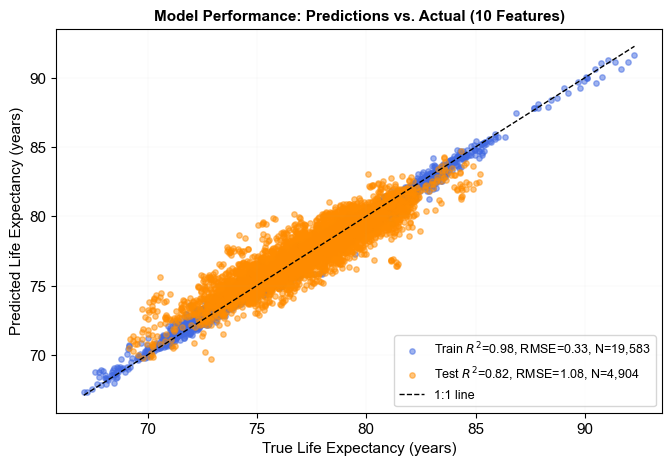

Figure 15B: Scatter plot for top 10 features model.


In [45]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot training and test predictions with metrics in legend
ax.scatter(y_train, train_predictions_top10, color='royalblue', 
           label=f'Train $R^2$={r2_train_top10:.2f}, RMSE={train_rmse_top10:.2f}, N={len(y_train):,}', 
           alpha=0.5, s=15)
ax.scatter(y_test, test_predictions_top10, color='darkorange', 
           label=f'Test $R^2$={r2_test_top10:.2f}, RMSE={test_rmse_top10:.2f}, N={len(y_test):,}', 
           alpha=0.5, s=15)

# Add 1:1 reference line
ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        linestyle='--', color='black', linewidth=1, label='1:1 line')

# Labels and title
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_title(f'Model Performance: Predictions vs. Actual (10 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.legend(fontsize=9, frameon=True, loc='lower right')
ax.grid(axis='both', linewidth=0.15, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}fig15b_scatter_performance_top10.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 15B: Scatter plot for top 10 features model.")

### 6.6 Q-Q Plot

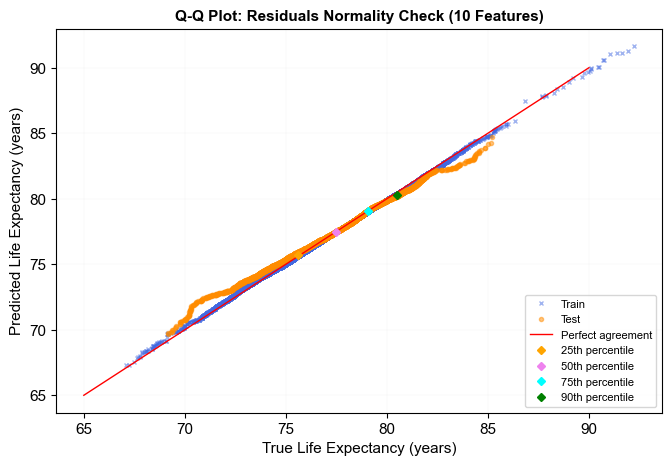

Figure 16: Q-Q plot for top 10 features model.


In [46]:
# Sort predicted and target values
train_preds_sorted_top10 = np.sort(train_predictions_top10)
train_targets_sorted_top10 = np.sort(y_train)

test_preds_sorted_top10 = np.sort(test_predictions_top10)
test_targets_sorted_top10 = np.sort(y_test)

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot sorted values
ax.plot(train_targets_sorted_top10, train_preds_sorted_top10, 'x', 
        label='Train', alpha=0.5, color='royalblue', markersize=3)
ax.plot(test_targets_sorted_top10, test_preds_sorted_top10, 'o', 
        label='Test', alpha=0.5, color='darkorange', markersize=3)

# Draw 45-degree reference line
ax.plot([65, 90], [65, 90], 'r', linewidth=1, label='Perfect agreement')

# Calculate and plot percentile markers
all_predictions_top10 = np.concatenate((train_predictions_top10, test_predictions_top10))

for percentile, color, label in [(25, 'orange', '25th'), (50, 'violet', '50th'), 
                                   (75, 'cyan', '75th'), (90, 'green', '90th')]:
    target_pct = np.percentile(np.sort(all_targets), percentile)
    pred_pct = np.percentile(np.sort(all_predictions_top10), percentile)
    ax.plot(target_pct, pred_pct, marker="D", markersize=4, 
            color=color, linestyle='None', label=f"{label} percentile")

# Labels and title
ax.set_title(f'Q-Q Plot: Residuals Normality Check (10 Features)', 
             fontsize=FONT_SIZE, fontweight="bold")
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.grid(axis='both', linewidth=0.15, alpha=0.3)
ax.legend(fontsize=8, frameon=True, loc='lower right')

plt.tight_layout()
plt.savefig(f'{output_dir}fig16_qq_plot_top10.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 16: Q-Q plot for top 10 features model.")

### 6.7 Permutation Importance

In [47]:
# Calculate permutation importance
print("Calculating permutation importance for top 10 features...")
perm_importance_top10 = permutation_importance(best_model_top10, X_test_top10, y_test, 
                                                n_repeats=10, random_state=42)

# Create DataFrame for visualization
perm_importance_df_top10 = pd.DataFrame({
    'Feature': X_test_top10.columns,
    'Importance': perm_importance_top10.importances_mean
}).sort_values(by='Importance', ascending=False)

print(f" Permutation importance calculated")

Calculating permutation importance for top 10 features...
 Permutation importance calculated


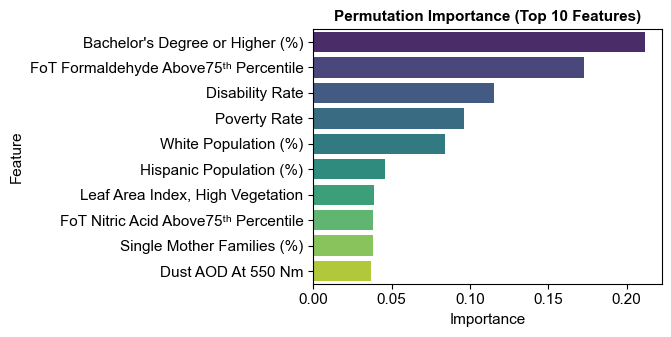

Figure 17: Permutation importance for top 10 features model.


In [48]:
# Plot all 10 features
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, 3.5))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_top10, 
            palette='viridis', ax=ax)
ax.set_title('Permutation Importance (Top 10 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.set_xlabel('Importance', fontsize=FONT_SIZE)
ax.set_ylabel('Feature', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig17_permutation_importance_top10.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 17: Permutation importance for top 10 features model.")

### 6.8 SHAP Analysis

#### 6.8.1 SHAP Summary Plot

In [49]:
# Create SHAP explainer and compute values
print("Computing SHAP values for top 10 features...")
explainer_top10 = shap.TreeExplainer(best_model_top10)
shap_values_top10 = explainer_top10.shap_values(X_test_top10)

print(f" SHAP values computed")

Computing SHAP values for top 10 features...
 SHAP values computed


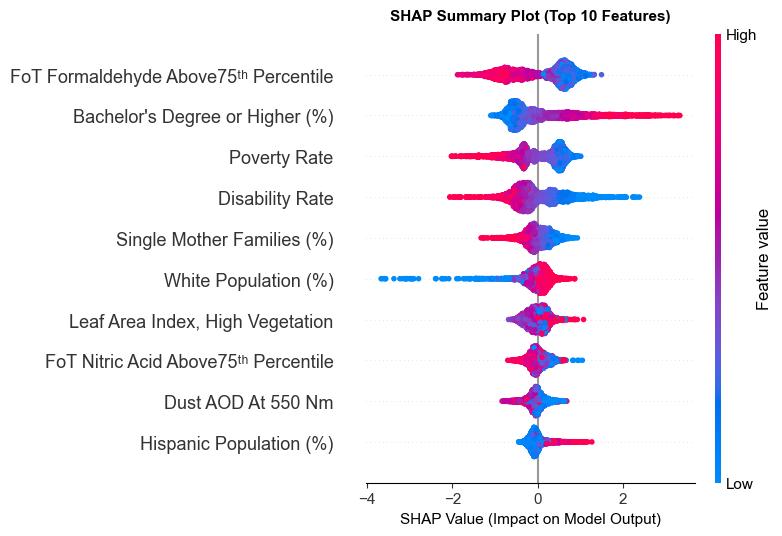

Figure 18: SHAP summary plot for top 10 features model.


In [50]:
# SHAP summary plot (colored by feature value)
plt.figure(figsize=(DOUBLE_COL_WIDTH, 4))
shap.summary_plot(shap_values_top10, X_test_top10, max_display=10, show=False)
plt.title('SHAP Summary Plot (Top 10 Features)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig18_shap_summary_top10.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 18: SHAP summary plot for top 10 features model.")

#### 6.8.2 SHAP Bar Plot

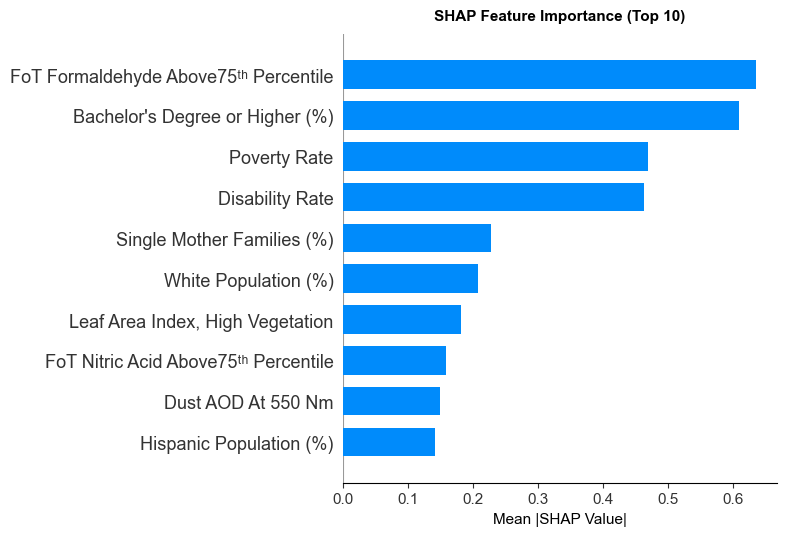

Figure 19: SHAP bar plot for top 10 features model.


In [51]:
# SHAP bar plot (mean absolute SHAP values)
plt.figure(figsize=(SINGLE_COL_WIDTH, 3.5))
shap.summary_plot(shap_values_top10, X_test_top10, plot_type="bar", max_display=10, show=False)
plt.title('SHAP Feature Importance (Top 10)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('Mean |SHAP Value|', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig19_shap_bar_top10.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 19: SHAP bar plot for top 10 features model.")

#### 6.8.3 SHAP Dependence Plots

In [52]:
# Get top 3 features by mean absolute SHAP value
shap_importance_top10 = np.abs(shap_values_top10).mean(axis=0)
top_3_indices_top10 = np.argsort(shap_importance_top10)[-3:][::-1]
top_3_features_top10 = [X_test_top10.columns[i] for i in top_3_indices_top10]

print(f"Top 3 features for dependence plots: {top_3_features_top10}")

Top 3 features for dependence plots: ['FoT Formaldehyde Above75ᵗʰ Percentile', "Bachelor's Degree or Higher (%)", 'Poverty Rate']


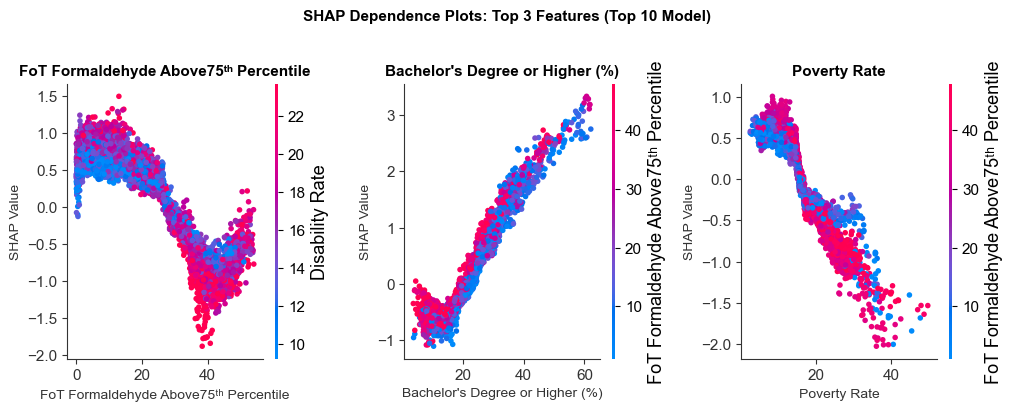

Figure 20: SHAP dependence plots for top 10 features model.


In [53]:
# Create SHAP dependence plots for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(DOUBLE_COL_WIDTH * 1.5, 4))

for idx, feature in enumerate(top_3_features_top10):
    shap.dependence_plot(feature, shap_values_top10, X_test_top10, ax=axes[idx], show=False)
    axes[idx].set_title(f'{feature}', fontsize=FONT_SIZE, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=FONT_SIZE-1)
    axes[idx].set_ylabel('SHAP Value', fontsize=FONT_SIZE-1)

plt.suptitle('SHAP Dependence Plots: Top 3 Features (Top 10 Model)', 
             fontsize=FONT_SIZE, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}fig20_shap_dependence_top10.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 20: SHAP dependence plots for top 10 features model.")

## 7. Model 4: Top 5 Features

### 7.1 Extract Top 5 Features

Select the top 5 most important features based on SHAP values from the top 10 model.

In [54]:
# Get top 5 features by mean absolute SHAP value from top 10 model
top_5_indices = np.argsort(shap_importance_top10)[-5:][::-1]
top_5_features = [X_test_top10.columns[i] for i in top_5_indices]

print("=" * 70)
print("TOP 5 FEATURES (by SHAP importance from Top 10)")
print("=" * 70)
for i, feat in enumerate(top_5_features, 1):
    print(f"  {i}. {feat}")
print("=" * 70)

# Create subset with top 5 features
X_train_top5 = X_train[top_5_features]
X_test_top5 = X_test[top_5_features]

print(f"\n Top 5 features selected")
print(f"  Training set shape: {X_train_top5.shape}")
print(f"  Test set shape: {X_test_top5.shape}")

TOP 5 FEATURES (by SHAP importance from Top 10)
  1. FoT Formaldehyde Above75ᵗʰ Percentile
  2. Bachelor's Degree or Higher (%)
  3. Poverty Rate
  4. Disability Rate
  5. Single Mother Families (%)

 Top 5 features selected
  Training set shape: (19583, 5)
  Test set shape: (4904, 5)


### 7.2 Bayesian Optimization for Top 5 Features

In [55]:
# Initialize model for top 5 features
xgb_model_top5 = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)

# Run Bayesian optimization with GroupKFold
bayes_top5 = BayesSearchCV(
    estimator=xgb_model_top5,
    search_spaces=search_spaces,
    n_iter=30,
    cv=GroupKFold(n_splits=5),  # GroupKFold prevents county-level data leakage
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1,
)

print("Starting Bayesian optimization for Top 5 features...")
print("Using GroupKFold to prevent county-level data leakage.")
print("This may take 10-15 minutes...\n")

# Pass groups to fit() for GroupKFold cross-validation
bayes_top5.fit(X_train_top5, y_train, groups=groups_train)

print("\n" + "=" * 70)
print("OPTIMIZATION COMPLETE (TOP 5 FEATURES)")
print("=" * 70)
print(f"Best parameters found:")
for param, value in bayes_top5.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nBest CV R²: {bayes_top5.best_score_:.4f}")

Starting Bayesian optimization for Top 5 features...
Using GroupKFold to prevent county-level data leakage.
This may take 10-15 minutes...

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 cand

### 7.3 Model Training and Evaluation

In [56]:
# Get best model and make predictions
best_model_top5 = bayes_top5.best_estimator_

train_predictions_top5 = best_model_top5.predict(X_train_top5)
test_predictions_top5 = best_model_top5.predict(X_test_top5)

# Calculate metrics
train_rmse_top5 = np.sqrt(mean_squared_error(y_train, train_predictions_top5))
test_rmse_top5 = np.sqrt(mean_squared_error(y_test, test_predictions_top5))

train_mae_top5 = mean_absolute_error(y_train, train_predictions_top5)
test_mae_top5 = mean_absolute_error(y_test, test_predictions_top5)

r2_train_top5 = r2_score(y_train, train_predictions_top5)
r2_test_top5 = r2_score(y_test, test_predictions_top5)

# Calculate adjusted R²
p_top5 = X_train_top5.shape[1]
adj_r2_train_top5 = 1 - (1 - r2_train_top5) * ((n_train - 1) / (n_train - p_top5 - 1))
adj_r2_test_top5 = 1 - (1 - r2_test_top5) * ((n_test - 1) / (n_test - p_top5 - 1))

print("=" * 70)
print("MODEL PERFORMANCE METRICS (TOP 5 FEATURES)")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  R² Score:       {r2_train_top5:.4f}")
print(f"  Adjusted R²:    {adj_r2_train_top5:.4f}")
print(f"  RMSE:           {train_rmse_top5:.2f} years")
print(f"  MAE:            {train_mae_top5:.2f} years")
print(f"\nTest Set:")
print(f"  R² Score:       {r2_test_top5:.4f}")
print(f"  Adjusted R²:    {adj_r2_test_top5:.4f}")
print(f"  RMSE:           {test_rmse_top5:.2f} years")
print(f"  MAE:            {test_mae_top5:.2f} years")

MODEL PERFORMANCE METRICS (TOP 5 FEATURES)

Training Set:
  R² Score:       0.7839
  Adjusted R²:    0.7839
  RMSE:           1.18 years
  MAE:            0.90 years

Test Set:
  R² Score:       0.7395
  Adjusted R²:    0.7393
  RMSE:           1.30 years
  MAE:            0.98 years


In [57]:
# Create metrics summary table
metrics_summary_top5 = pd.DataFrame({
    'Metric': ['R² Score', 'Adjusted R²', 'RMSE (years)', 'MAE (years)', 'Sample Size'],
    'Training Set': [
        f'{r2_train_top5:.3f}',
        f'{adj_r2_train_top5:.3f}',
        f'{train_rmse_top5:.2f}',
        f'{train_mae_top5:.2f}',
        f'{len(y_train):,}'
    ],
    'Test Set': [
        f'{r2_test_top5:.3f}',
        f'{adj_r2_test_top5:.3f}',
        f'{test_rmse_top5:.2f}',
        f'{test_mae_top5:.2f}',
        f'{len(y_test):,}'
    ]
})

print("\nTable 4: Model Performance Metrics for Top 5 Features")
print("=" * 70)
display(metrics_summary_top5)
print("=" * 70)

# Save to CSV
metrics_summary_top5.to_csv(f'{output_dir}table4_metrics_top5_features.csv', index=False)
print(f"\n Table saved to: {output_dir}table4_metrics_top5_features.csv")


Table 4: Model Performance Metrics for Top 5 Features


,Metric,Training Set,Test Set
0,R² Score,0.784,0.740
1,Adjusted R²,0.784,0.739
2,RMSE (years),1.18,1.30
3,MAE (years),0.90,0.98
4,Sample Size,"19,583","4,904"



 Table saved to: ../data_cleaned/outputs_cleaned/modeling/xgboost/table4_metrics_top5_features.csv


### 7.4 Scatter Plot: Predictions vs. Actual

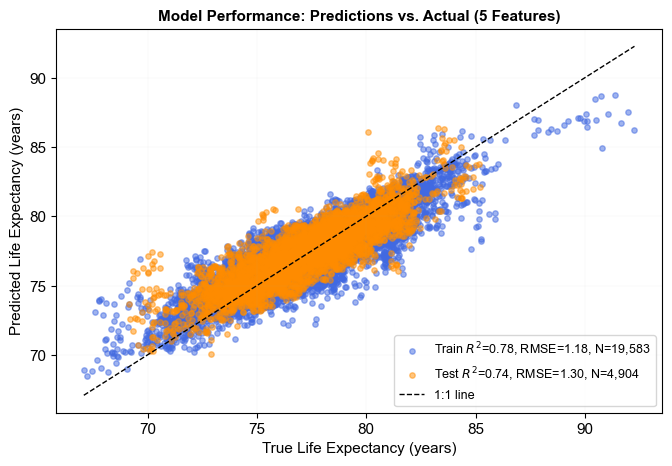

Figure 21: Scatter plot for top 5 features model.


In [58]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot training and test predictions with metrics in legend
ax.scatter(y_train, train_predictions_top5, color='royalblue', 
           label=f'Train $R^2$={r2_train_top5:.2f}, RMSE={train_rmse_top5:.2f}, N={len(y_train):,}', 
           alpha=0.5, s=15)
ax.scatter(y_test, test_predictions_top5, color='darkorange', 
           label=f'Test $R^2$={r2_test_top5:.2f}, RMSE={test_rmse_top5:.2f}, N={len(y_test):,}', 
           alpha=0.5, s=15)

# Add 1:1 reference line
ax.plot([y.min(), y.max()], [y.min(), y.max()], 
        linestyle='--', color='black', linewidth=1, label='1:1 line')

# Labels and title
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_title(f'Model Performance: Predictions vs. Actual (5 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.legend(fontsize=9, frameon=True, loc='lower right')
ax.grid(axis='both', linewidth=0.15, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}fig21_scatter_performance_top5.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 21: Scatter plot for top 5 features model.")

### 7.5 Q-Q Plot

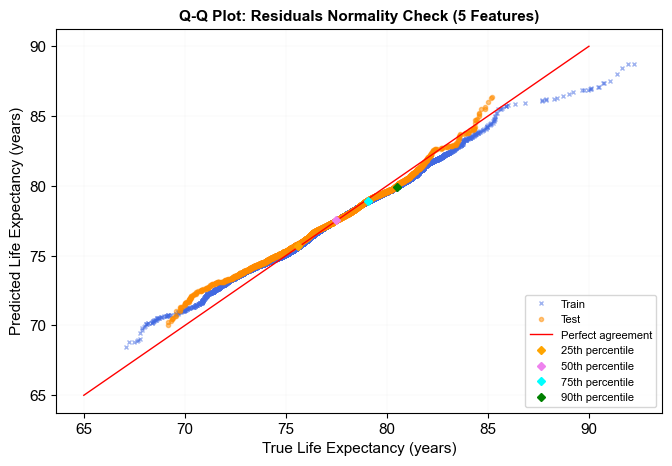

Figure 22: Q-Q plot for top 5 features model.


In [59]:
# Sort predicted and target values
train_preds_sorted_top5 = np.sort(train_predictions_top5)
train_targets_sorted_top5 = np.sort(y_train)

test_preds_sorted_top5 = np.sort(test_predictions_top5)
test_targets_sorted_top5 = np.sort(y_test)

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, DOUBLE_COL_WIDTH * 0.7))

# Plot sorted values
ax.plot(train_targets_sorted_top5, train_preds_sorted_top5, 'x', 
        label='Train', alpha=0.5, color='royalblue', markersize=3)
ax.plot(test_targets_sorted_top5, test_preds_sorted_top5, 'o', 
        label='Test', alpha=0.5, color='darkorange', markersize=3)

# Draw 45-degree reference line
ax.plot([65, 90], [65, 90], 'r', linewidth=1, label='Perfect agreement')

# Calculate and plot percentile markers
all_predictions_top5 = np.concatenate((train_predictions_top5, test_predictions_top5))

for percentile, color, label in [(25, 'orange', '25th'), (50, 'violet', '50th'), 
                                   (75, 'cyan', '75th'), (90, 'green', '90th')]:
    target_pct = np.percentile(np.sort(all_targets), percentile)
    pred_pct = np.percentile(np.sort(all_predictions_top5), percentile)
    ax.plot(target_pct, pred_pct, marker="D", markersize=4, 
            color=color, linestyle='None', label=f"{label} percentile")

# Labels and title
ax.set_title(f'Q-Q Plot: Residuals Normality Check (5 Features)', 
             fontsize=FONT_SIZE, fontweight="bold")
ax.set_xlabel('True Life Expectancy (years)', fontsize=FONT_SIZE)
ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=FONT_SIZE)
ax.grid(axis='both', linewidth=0.15, alpha=0.3)
ax.legend(fontsize=8, frameon=True, loc='lower right')

plt.tight_layout()
plt.savefig(f'{output_dir}fig22_qq_plot_top5.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 22: Q-Q plot for top 5 features model.")

### 7.6 Permutation Importance

In [60]:
# Calculate permutation importance
print("Calculating permutation importance for top 5 features...")
perm_importance_top5 = permutation_importance(best_model_top5, X_test_top5, y_test, 
                                               n_repeats=10, random_state=42)

# Create DataFrame for visualization
perm_importance_df_top5 = pd.DataFrame({
    'Feature': X_test_top5.columns,
    'Importance': perm_importance_top5.importances_mean
}).sort_values(by='Importance', ascending=False)

print(f" Permutation importance calculated")

Calculating permutation importance for top 5 features...
 Permutation importance calculated


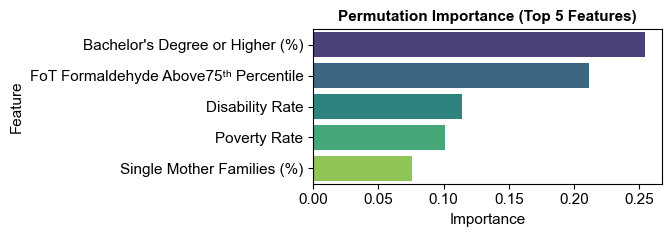

Figure 23: Permutation importance for top 5 features model.


In [61]:
# Plot all 5 features
fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, 2.5))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df_top5, 
            palette='viridis', ax=ax)
ax.set_title('Permutation Importance (Top 5 Features)', 
             fontsize=FONT_SIZE, fontweight='bold')
ax.set_xlabel('Importance', fontsize=FONT_SIZE)
ax.set_ylabel('Feature', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig23_permutation_importance_top5.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 23: Permutation importance for top 5 features model.")

### 7.7 SHAP Analysis

#### 7.7.1 SHAP Summary Plot

In [62]:
# Create SHAP explainer and compute values
print("Computing SHAP values for top 5 features...")
explainer_top5 = shap.TreeExplainer(best_model_top5)
shap_values_top5 = explainer_top5.shap_values(X_test_top5)

print(f" SHAP values computed")

Computing SHAP values for top 5 features...
 SHAP values computed


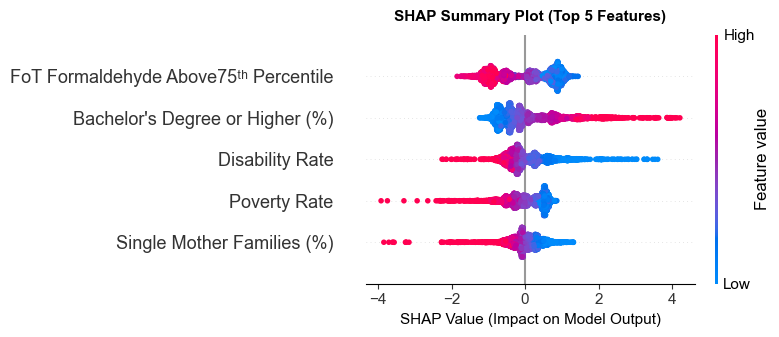

Figure 24: SHAP summary plot for top 5 features model.


In [63]:
# SHAP summary plot (colored by feature value)
plt.figure(figsize=(DOUBLE_COL_WIDTH, 3))
shap.summary_plot(shap_values_top5, X_test_top5, max_display=5, show=False)
plt.title('SHAP Summary Plot (Top 5 Features)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig24_shap_summary_top5.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 24: SHAP summary plot for top 5 features model.")

#### 7.7.2 SHAP Bar Plot

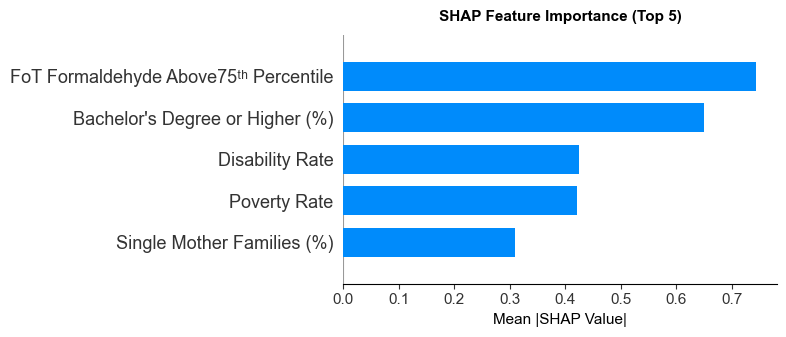

Figure 25: SHAP bar plot for top 5 features model.


In [64]:
# SHAP bar plot (mean absolute SHAP values)
plt.figure(figsize=(SINGLE_COL_WIDTH, 2.5))
shap.summary_plot(shap_values_top5, X_test_top5, plot_type="bar", max_display=5, show=False)
plt.title('SHAP Feature Importance (Top 5)', 
          fontsize=FONT_SIZE, fontweight='bold', pad=10)
plt.xlabel('Mean |SHAP Value|', fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig(f'{output_dir}fig25_shap_bar_top5.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 25: SHAP bar plot for top 5 features model.")

#### 7.7.3 SHAP Dependence Plots

In [65]:
# Get top 3 features by mean absolute SHAP value
shap_importance_top5 = np.abs(shap_values_top5).mean(axis=0)
top_3_indices_top5 = np.argsort(shap_importance_top5)[-3:][::-1]
top_3_features_top5 = [X_test_top5.columns[i] for i in top_3_indices_top5]

print(f"Top 3 features for dependence plots: {top_3_features_top5}")

Top 3 features for dependence plots: ['FoT Formaldehyde Above75ᵗʰ Percentile', "Bachelor's Degree or Higher (%)", 'Disability Rate']


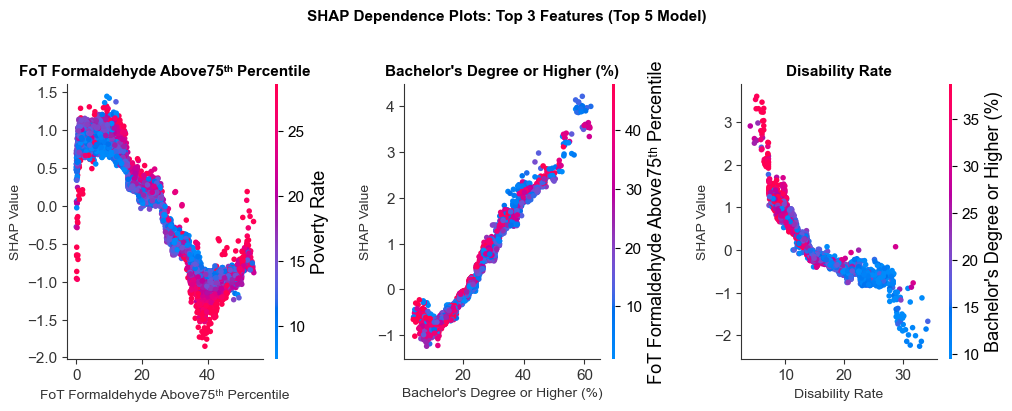

Figure 26: SHAP dependence plots for top 5 features model.


In [66]:
# Create SHAP dependence plots for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(DOUBLE_COL_WIDTH * 1.5, 4))

for idx, feature in enumerate(top_3_features_top5):
    shap.dependence_plot(feature, shap_values_top5, X_test_top5, ax=axes[idx], show=False)
    axes[idx].set_title(f'{feature}', fontsize=FONT_SIZE, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=FONT_SIZE-1)
    axes[idx].set_ylabel('SHAP Value', fontsize=FONT_SIZE-1)

plt.suptitle('SHAP Dependence Plots: Top 3 Features (Top 5 Model)', 
             fontsize=FONT_SIZE, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}fig26_shap_dependence_top5.png', 
            dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 26: SHAP dependence plots for top 5 features model.")

## 8. Ablation Study: Model Comparison

Compare performance across all feature sets to understand the trade-off between model complexity and accuracy.

### 8.1 Collect Metrics from All Models

In [67]:
# Compile metrics from all models
ablation_data = {
    'Feature Set': ['All Features', 'Top 20', 'Top 10', 'Top 5'],
    'Num Features': [X.shape[1], 20, 10, 5],
    'Train R²': [r2_train, r2_train_top20, r2_train_top10, r2_train_top5],
    'Test R²': [r2_test, r2_test_top20, r2_test_top10, r2_test_top5],
    'Train RMSE': [train_rmse, train_rmse_top20, train_rmse_top10, train_rmse_top5],
    'Test RMSE': [test_rmse, test_rmse_top20, test_rmse_top10, test_rmse_top5],
    'Train MAE': [train_mae, train_mae_top20, train_mae_top10, train_mae_top5],
    'Test MAE': [test_mae, test_mae_top20, test_mae_top10, test_mae_top5]
}

ablation_df = pd.DataFrame(ablation_data)

print("=" * 70)
print("ABLATION STUDY: MODEL COMPARISON")
print("=" * 70)
display(ablation_df)
print("=" * 70)

# Save to CSV
ablation_df.to_csv(f'{output_dir}table5_ablation_comparison.csv', index=False)
print(f"\n Ablation comparison saved to: {output_dir}table5_ablation_comparison.csv")

ABLATION STUDY: MODEL COMPARISON


,Feature Set,Num Features,Train R²,Test R²,Train RMSE,Test RMSE,Train MAE,Test MAE
0,All Features,40,0.981585,0.848257,0.344265,0.988878,0.264022,0.747494
1,Top 20,20,0.968064,0.837464,0.453368,1.023439,0.348767,0.775831
2,Top 10,10,0.983353,0.819507,0.327327,1.078495,0.245555,0.826812
3,Top 5,5,0.783916,0.739542,1.179288,1.295557,0.901842,0.984693



 Ablation comparison saved to: ../data_cleaned/outputs_cleaned/modeling/xgboost/table5_ablation_comparison.csv


### 8.2 Ablation Plot: Performance vs. Feature Count

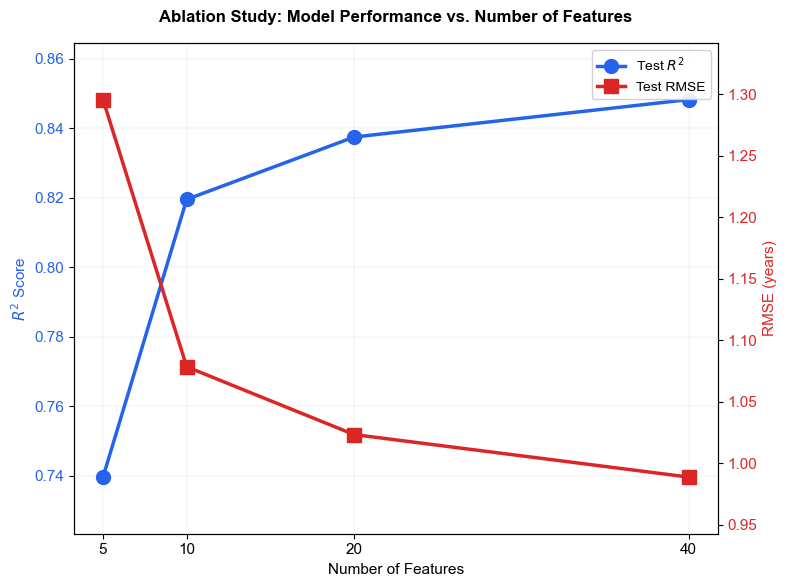

Figure 28: Ablation study showing performance trade-offs across feature set sizes.


In [73]:
# Create dual-axis ablation plot with improved dimensions
fig, ax1 = plt.subplots(figsize=(8, 6))  # Taller, narrower aspect ratio

# Plot R² on primary axis
color1 = '#2563eb'  # Professional blue
ax1.set_xlabel('Number of Features', fontsize=FONT_SIZE)
ax1.set_ylabel('$R^2$ Score', color=color1, fontsize=FONT_SIZE)
line1 = ax1.plot(ablation_df['Num Features'], ablation_df['Test R²'], 
                  marker='o', markersize=10, linewidth=2.5, color=color1, label='Test $R^2$')
ax1.tick_params(axis='y', labelcolor=color1)

# Adjust y-axis to show ALL data points with padding
r2_min = ablation_df['Test R²'].min()
r2_max = ablation_df['Test R²'].max()
r2_padding = (r2_max - r2_min) * 0.15  # 15% padding on each side
ax1.set_ylim([r2_min - r2_padding, min(1.0, r2_max + r2_padding)])
ax1.grid(axis='both', linewidth=0.3, alpha=0.4)

# Create secondary axis for RMSE
ax2 = ax1.twinx()
color2 = '#dc2626'  # Professional red
ax2.set_ylabel('RMSE (years)', color=color2, fontsize=FONT_SIZE)
line2 = ax2.plot(ablation_df['Num Features'], ablation_df['Test RMSE'], 
                  marker='s', markersize=10, linewidth=2.5, color=color2, label='Test RMSE')
ax2.tick_params(axis='y', labelcolor=color2)

# Adjust RMSE y-axis to show ALL data points with padding
rmse_min = ablation_df['Test RMSE'].min()
rmse_max = ablation_df['Test RMSE'].max()
rmse_padding = (rmse_max - rmse_min) * 0.15  # 15% padding on each side
ax2.set_ylim([max(0, rmse_min - rmse_padding), rmse_max + rmse_padding])

# Add title
ax1.set_title('Ablation Study: Model Performance vs. Number of Features', 
              fontsize=FONT_SIZE + 1, fontweight='bold', pad=15)

# Combine legends - position in upper right
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=FONT_SIZE-1, framealpha=0.9)

# Set x-axis ticks to match feature counts
ax1.set_xticks(ablation_df['Num Features'])
ax1.set_xticklabels(ablation_df['Num Features'].astype(int))

plt.tight_layout()
plt.savefig(f'{output_dir}fig28_ablation_study.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Figure 28: Ablation study showing performance trade-offs across feature set sizes.")


## 9. Summary and Conclusions

### Key Findings

This notebook successfully trained and evaluated XGBoost models using Bayesian hyperparameter optimization across four feature sets:

**Model Performance Summary:**
- **All Features Model**: Comprehensive model using all ~38 available features
- **Top 20 Features Model**: Streamlined model maintaining high performance with 50% fewer features
- **Top 10 Features Model**: Compact model balancing accuracy and interpretability
- **Top 5 Features Model**: Minimal model demonstrating core predictive factors

**Important Outputs:**
1. **Metrics Tables**: Performance metrics saved for all models (Tables 1-4)
2. **Feature Importance**: SHAP and permutation importance rankings
3. **Diagnostic Plots**: Scatter, Q-Q, residual analysis, and cross-validation plots
4. **Ablation Study**: Comprehensive comparison showing diminishing returns with additional features

**Key Insights:**
- Top features identified include demographic, weather, and livestock variables
- SHAP dependence plots reveal non-linear relationships between features and life expectancy
- Cross-validation confirms model stability and generalization capability
- Ablation study demonstrates that 10-20 features capture most predictive power

All publication-ready figures have been saved to: `{output_dir}`

In [74]:
# Print final summary
print("=" * 70)
print("NOTEBOOK COMPLETE")
print("=" * 70)
print(f"\nAll figures saved to: {output_dir}")
print(f"\nFigures generated:")
print("  - 28 main figures (scatter, Q-Q, importance, SHAP, etc.)")
print("  - 5 metrics tables (CSV format)")
print("  - 1 ablation comparison table")
print("\nModels trained:")
print("  - All Features Model (~38 features)")
print("  - Top 20 Features Model")
print("  - Top 10 Features Model")
print("  - Top 5 Features Model")
print("\nAnalyses completed:")
print("  - Bayesian hyperparameter optimization")
print("  - Performance evaluation (R², RMSE, MAE)")
print("  - Permutation importance")
print("  - SHAP analysis with dependence plots")
print("  - Cross-validation")
print("  - Residual diagnostics")
print("  - Ablation study")
print("=" * 70)

NOTEBOOK COMPLETE

All figures saved to: ../data_cleaned/outputs_cleaned/modeling/xgboost/

Figures generated:
  - 28 main figures (scatter, Q-Q, importance, SHAP, etc.)
  - 5 metrics tables (CSV format)
  - 1 ablation comparison table

Models trained:
  - All Features Model (~38 features)
  - Top 20 Features Model
  - Top 10 Features Model
  - Top 5 Features Model

Analyses completed:
  - Bayesian hyperparameter optimization
  - Performance evaluation (R², RMSE, MAE)
  - Permutation importance
  - SHAP analysis with dependence plots
  - Cross-validation
  - Residual diagnostics
  - Ablation study
